In [ ]:
'''
Finds all the F_abstractions reactions in each model created by David that uses halogen chemistry. 
Compares Ea's of F_abstraction and  H_abstraction.
'''

Training reactions using AutoTST

In [5]:
import cantera as ct
import rmgpy.chemkin
import os
import numpy as np
import matplotlib.pylab as plt
import re
import numpy as np
import collections
%matplotlib inline

# Functions 

In [6]:
def load_chemkin_file(path): 
    """ 
    Load Chemkin file and extract the reactions and species.
    Path should be the path to the species folder.
    """
    
    full_path = os.path.join(path,'chemkin')
    chemkin_path = os.path.join(full_path,'copies', 'copy_chem_annotated.inp')
   # chemkin_path = os.path.join(full_path,'chem_annotated.inp')
    dictionary_path = os.path.join(full_path,'species_dictionary.txt')
    transport_path = os.path.join(full_path,'tran.dat')

    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)

    return species_list, reaction_list


In [7]:
def categorize_reactions(reaction_list):
    """
    Identify H, F-Abstraction reactions and save them to a list. 
    """
 
    #lists for storing data
    H_Abstractions = []
    F_Abstractions = []

    #identify reactions and save to lists 
    for rxn in reaction_list:
        try: 
            if rxn.family == 'H_Abstraction':
                H_Abstractions.append(rxn)
            if rxn.family == 'F_Abstraction':
                F_Abstractions.append(rxn)
        except AttributeError: 
            #pass when following error occurs: "AttributeError: 'PDepReaction' object has no attribute 'family' "
             pass
    
    
    return H_Abstractions, F_Abstractions

    

In [8]:
def generate_Cantera_object(full_path,T,P): 
    """
    Using supplied path, make a Cantera Solution object out of the CTI in this species folder. 
    """
    path_to_cti = os.path.join(full_path,"cantera", "chem_annotated.cti")
    gas = ct.Solution(path_to_cti)
    gas.TP = T, P
    
    return gas
 

In [9]:
def get_reaction_rates(gas, RMG_reactions_of_interest): 
    """
    Use Cantera to get the forward_rates_constants of each reaction.
    Returns a dictionary with key = rmg_reaction, value = [matching Cantera rxn, forward_rate_constant]
    """
    
    #this is a dictionary that will store our data. key = rmg_reaction, value = [matching Cantera rxn, forward_rate_constant]
    rxn_dict = {}
    #list to store rates that will be graphed
    rates = []


    for index, cantera_tuple in enumerate(zip(gas.reactions(), gas.forward_rate_constants)):

        cantera_rxn, rate = cantera_tuple 

        #extract reactants and products from each Cantera reaction and make them sets so we can compare them to other sets
        cantera_reactants = set([reactant for reactant in cantera_rxn.reactants.keys()])
        cantera_products = set([product for product in cantera_rxn.products.keys()])

        #iterate through RMG reactions of interest. For example, these reactions can be the F- of H-Abstraction reactions
        for rxn in RMG_reactions_of_interest:    

            #create empty lists that will store the reactants and products of each RMG reaction of interest.
            RMG_reactants = []
            RMG_products = []

            for reactant in rxn.reactants: 
                RMG_reactants.append(reactant.to_chemkin()) #use "to_chemkin" because we don't want the default smiles label
            for product in rxn.products:
                RMG_products.append(product.to_chemkin())

            #convert the lists to sets 
            rmg_products = set(RMG_products)
            rmg_reactants = set(RMG_reactants)
            
            #compare sets. If the reactants and products of a Cantera reaction and RMG reaction matches, they must be the same reaction. 
            if (cantera_reactants == rmg_reactants) and (cantera_products == rmg_products): 

                #save to dictionary, along with the forward_rate_constant for that reaction. Keep this dictionary in case you want to see if reactions actually match.
                rxn_dict[rxn] = [cantera_rxn, np.log(float(rate))]
                
                #save rates to a separate list
                rates.append(rate)

            else:
                continue

    #make sure we have found matching Cantera rxns for all RMG reactions of interest
    assert len(RMG_reactions_of_interest)==len(rxn_dict.keys())
    
######## get rid of duplicates ##############

    #two lists for storing unduplicated (1) tuples structured as (cantera_rxn, rate), (2) rmg reactions, (3) rates
    list_no_dups = []                 #1
    rmg_reaction_list_no_dups = []    #2
    rate_list_no_dups = []            #3

    #eliminate duplicate reactions by appending the key (rmg_rxn) and value (tuple of (cantera_rxn, rate)) to list #1 
    [list_no_dups.append([k,v]) for k,v in rxn_dict.items() if [k,v] not in list_no_dups]
    
    #extract the RMG reaction for list #1
    for k,v in list_no_dups: 
        rmg_reaction, [cantera_rxn, rate] = k, v
        rmg_reaction_list_no_dups.append(rmg_reaction)
    
    #take the rate from from list #1
        rate_list_no_dups.append(rate)
        

    
    return rate_list_no_dups, rmg_reaction_list_no_dups

In [13]:
def get_Eas_rates(full_path, files_to_exclude, title, T, P):
    '''
    Give full path of the folder (refrigerants, suppressants, etc.), list of files in that destination that are not species folders,
    a title (i.e. "Suppressants"), and temp and pressure. 
    Gets Ea's and rates of H- and F-Abstraction reactions in the species folders. 
    '''
    
    print(title)
    species_folders = [file for file in os.listdir(full_path) if file not in files_to_exclude]
    
    for species in species_folders: 

        try: 
            species_folder_path = os.path.join(full_path, species)
            if os.path.exists(os.path.join(species_folder_path,'chemkin')):
                pass
            else: 
                continue
            species_list, reaction_list = load_chemkin_file(species_folder_path)
            H_Abstractions, F_Abstractions = categorize_reactions(reaction_list)


            print("*******************************************************************************************************")
            print(species)
            print('\n')
            print(f"Number of F_abstractions:     {len(F_Abstractions)} ")
            print(f"Number of H_abstractions:     {len(H_Abstractions)} ")
            print(f"Total reactions:              {len(reaction_list)}")
            print(f"F_abstraction percentage out of total reactions: {float((len(F_Abstractions)/len(reaction_list))*100):.1f} % ")
            print('\n')


            gas = generate_Cantera_object(species_folder_path,298,ct.one_atm)
            H_rates, H_rmg_rxn_list = get_reaction_rates(gas, H_Abstractions)
            F_rates, F_rmg_rxn_list = get_reaction_rates(gas, F_Abstractions)


            #get the activation energies for each reaction type
            H_Ea = np.array([float(rxn.kinetics.Ea.value) for rxn in H_rmg_rxn_list])
            F_Ea = np.array([float(rxn.kinetics.Ea.value) for rxn in F_rmg_rxn_list])

            #x axes to plot
            x_F = list(range(len(F_Ea)))
            x_H = list(range(len(F_Ea),len(F_Ea)+len(H_Ea)))

#              #plot the Ea's
#             fig, ax1 = plt.subplots()

#             ax1.scatter(x_F, F_Ea, c='r', label='F_abstraction')
#             ax1.scatter(x_H, H_Ea, c='m', label='H_abstraction')

#             #plot rates 
#             ax2 = ax1.twinx()
#             ax2.scatter(x_F, F_rates, c='b', marker = "v", label='F_abstraction rate')
#             ax2.scatter(x_H, H_rates, c='orange', marker = "v", label='H_abstraction rate')


#             plt.xlabel('Reactions')
#             ax1.set_ylabel('E_a (kcal/mol)')
#             ax2.set_ylabel('Forward Rate Constants: log(K)')
#             plt.title(f'Activation energy of F- and H-Abstraction reactions in {species} model')
#             ax1.legend()
#             ax2.legend()
#             plt.show()
            
            
            plt.scatter(F_Ea, F_rates, c='r', label='F_abstraction', alpha=0.3 )
            plt.scatter(H_Ea, H_rates, c='b', label='H_abstraction', alpha=0.3 )
            plt.xlabel('E_a (kcal/mol)')
            plt.ylabel('Forward Rate Constants: log(K)')
            plt.title(f'F-abstraction and H-abstraction reactions in {species} model')
            plt.legend()
            plt.show()
            
        
        except: 
            continue #i know this is very dangerous, but i dont care



In [17]:
species_list, reaction_list = load_chemkin_file('/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/F_abs/DF_models/rmg_combustion_paper_FFCM/suppressants/CF3Br/')

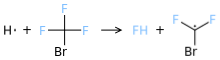

In [20]:
H_Abstractions, F_Abstractions = categorize_reactions(reaction_list)
r = F_Abstractions[0]
r

In [38]:
print(r.kinetics.Ea)
r.kinetics.Ea.value_si/r.kinetics.Ea.conversionFactors['kcal/mol']


30.738 kcal/mol


30.738

In [26]:
r.kinetics.get_rate_coefficient(T) # m3/mol/s

0.16958410745717453

In [47]:
def get_Eas_rates(full_path, files_to_exclude, title, T, P):
    '''
    Give full path of the folder (refrigerants, suppressants, etc.), list of files in that destination that are not species folders,
    a title (i.e. "Suppressants"), and temp and pressure. 
    Gets Ea's and rates of H- and F-Abstraction reactions in the species folders. 
    '''
    
    print(title)
    species_folders = [file for file in os.listdir(full_path) if file not in files_to_exclude]
    
    for species in species_folders: 

        try: 
            species_folder_path = os.path.join(full_path, species)
            if os.path.exists(os.path.join(species_folder_path,'chemkin')):
                pass
            else: 
                continue
            species_list, reaction_list = load_chemkin_file(species_folder_path)
            H_Abstractions, F_Abstractions = categorize_reactions(reaction_list)


            print("*******************************************************************************************************")
            print(species)
            print('\n')
            print(f"Number of F_abstractions:     {len(F_Abstractions)} ")
            print(f"Number of H_abstractions:     {len(H_Abstractions)} ")
            print(f"Total reactions:              {len(reaction_list)}")
            print(f"F_abstraction percentage out of total reactions: {float((len(F_Abstractions)/len(reaction_list))*100):.1f} % ")
            print('\n')

            F_Ea = [r.kinetics.Ea.value_si/r.kinetics.Ea.conversionFactors['kcal/mol'] for r in F_Abstractions]
            H_Ea = [r.kinetics.Ea.value_si/r.kinetics.Ea.conversionFactors['kcal/mol'] for r in H_Abstractions]
            
            F_rates = np.log10(np.array([r.kinetics.get_rate_coefficient(T,P) for r in F_Abstractions]))
            H_rates = np.log10(np.array([r.kinetics.get_rate_coefficient(T,P) for r in H_Abstractions]))
            
            plt.scatter(F_Ea, F_rates, c='r', label='F_abstraction', alpha=0.3 )
            plt.scatter(H_Ea, H_rates, c='b', label='H_abstraction', alpha=0.3 )
            plt.xlabel('E_a (kcal/mol)')
            plt.ylabel('Forward Rate Constants: log(k / (m3/mol/s))')
            plt.title(f'F-abstraction and H-abstraction reactions in {species} model')
            plt.legend()
            plt.show()
            
            
            for i,Ea in enumerate(F_Ea):
                if Ea < 20:
                    r = F_Abstractions[i]
                    display(r)
                    print(r.to_chemkin())
                    print()

        
        except: 
            continue #i know this is very dangerous, but i dont care


# Execute

Iterate over all Halogen Species created by David 

In [42]:
T = 1000 #K
P = ct.one_atm

## Suppressants 

Suppressants
*******************************************************************************************************
2-BTP


Number of F_abstractions:     14 
Number of H_abstractions:     332 
Total reactions:              2251
F_abstraction percentage out of total reactions: 0.6 % 




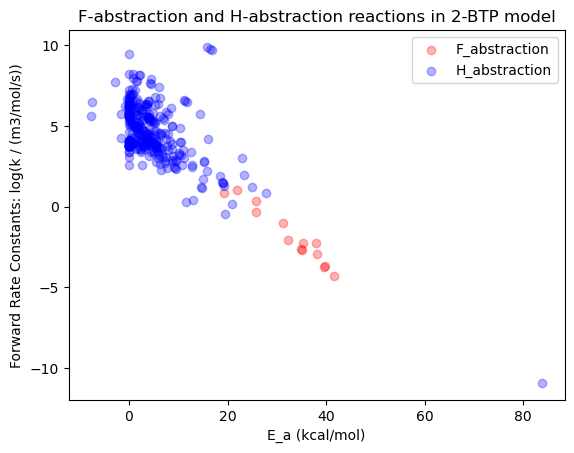

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FCBr(2160), CH2Br(362); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+FCBr(2160)=HF(38)+CH2Br(362)                   1.575380e-09 6.622     19.232   


*******************************************************************************************************
C3F7H


Number of F_abstractions:     38 
Number of H_abstractions:     154 
Total reactions:              1216
F_abstraction percentage out of total reactions: 3.1 % 




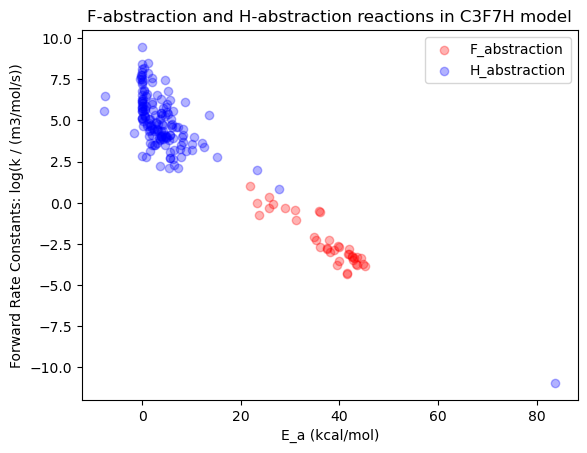

*******************************************************************************************************
CF2BrCHCH2


Number of F_abstractions:     0 
Number of H_abstractions:     45 
Total reactions:              1010
F_abstraction percentage out of total reactions: 0.0 % 




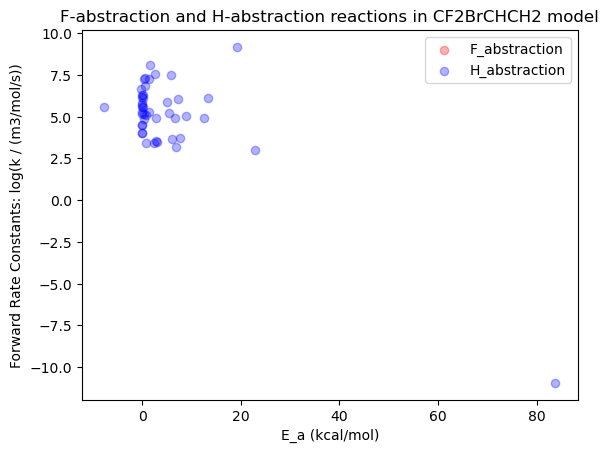

*******************************************************************************************************
CF2ClBr


Number of F_abstractions:     14 
Number of H_abstractions:     315 
Total reactions:              1692
F_abstraction percentage out of total reactions: 0.8 % 




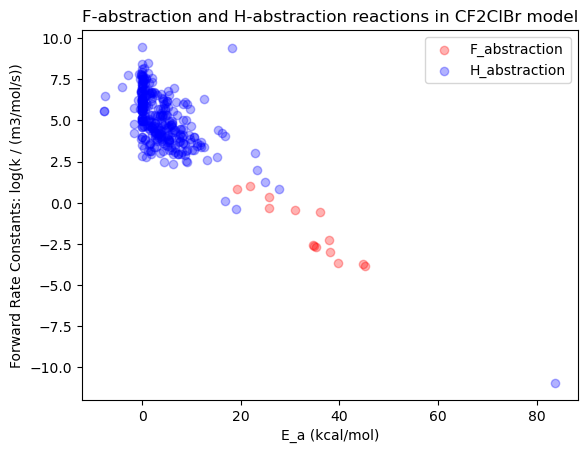

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FCBr(750), CH2Br(322); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+FCBr(750)=HF(38)+CH2Br(322)                    1.575380e-09 6.622     19.232   


*******************************************************************************************************
CF3Br


Number of F_abstractions:     1 
Number of H_abstractions:     198 
Total reactions:              1381
F_abstraction percentage out of total reactions: 0.1 % 




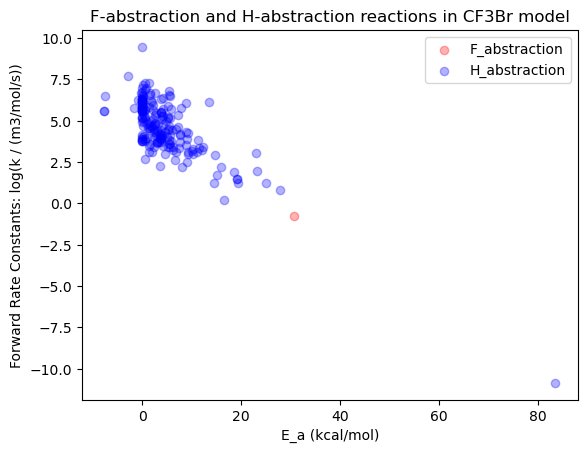

*******************************************************************************************************
CF3CBrCCF3


Number of F_abstractions:     14 
Number of H_abstractions:     368 
Total reactions:              2444
F_abstraction percentage out of total reactions: 0.6 % 




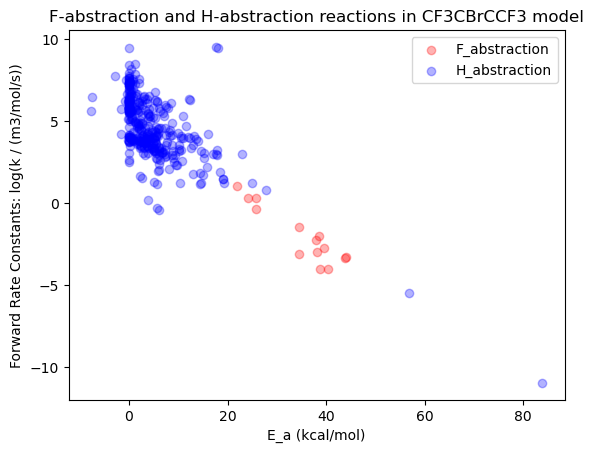

*******************************************************************************************************
CF3CBrCF2


Number of F_abstractions:     84 
Number of H_abstractions:     201 
Total reactions:              2021
F_abstraction percentage out of total reactions: 4.2 % 




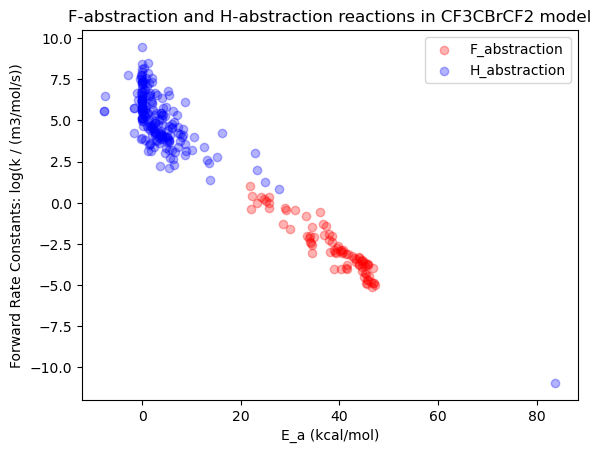

*******************************************************************************************************
CF3CBrCHF


Number of F_abstractions:     74 
Number of H_abstractions:     313 
Total reactions:              2968
F_abstraction percentage out of total reactions: 2.5 % 




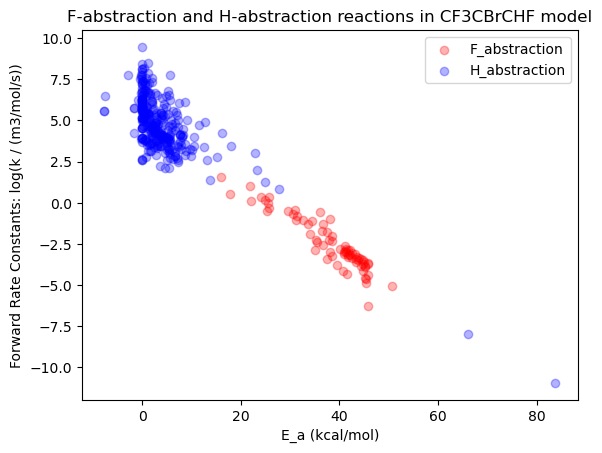

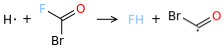

! Template reaction: F_Abstraction
! Flux pairs: S(1227), CBrO(291); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_Ext-1C-R
H(6)+S(1227)=HF(38)+CBrO(291)                       4.826740e-15 8.251     17.834   




! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(1643), HCCO(21); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(1643)=HF(38)+HCCO(21)                        1.575380e-09 6.622     16.047   


*******************************************************************************************************
CF3CHCl2


Number of F_abstractions:     158 
Number of H_abstractions:     208 
Total reactions:              1699
F_abstraction percentage out of total reactions: 9.3 % 




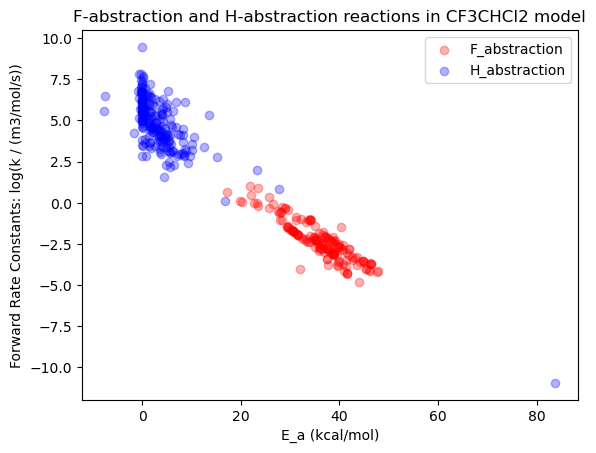

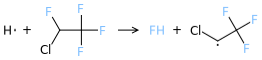

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(475), S(128); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_Ext-1C-R
H(6)+S(475)=HF(38)+S(128)                           4.826740e-15 8.251     17.294   




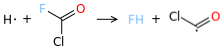

! Template reaction: F_Abstraction
! Flux pairs: CFCLO(118), CCLO(104); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_Ext-1C-R
H(6)+CFCLO(118)=HF(38)+CCLO(104)                    4.826740e-15 8.251     19.881   


*******************************************************************************************************
CF3H


Number of F_abstractions:     0 
Number of H_abstractions:     66 
Total reactions:              664
F_abstraction percentage out of total reactions: 0.0 % 




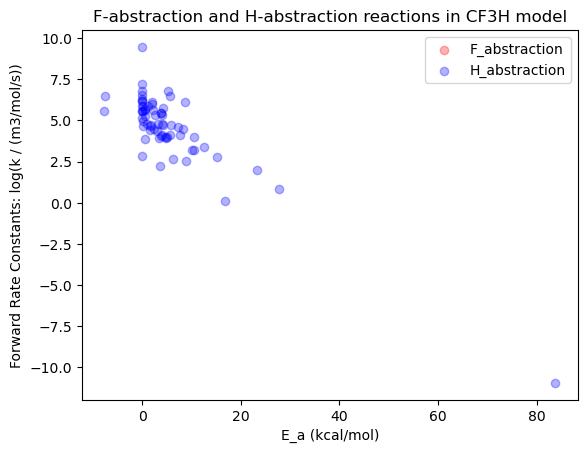

*******************************************************************************************************
CHF2CBrCH2


Number of F_abstractions:     3 
Number of H_abstractions:     143 
Total reactions:              1179
F_abstraction percentage out of total reactions: 0.3 % 




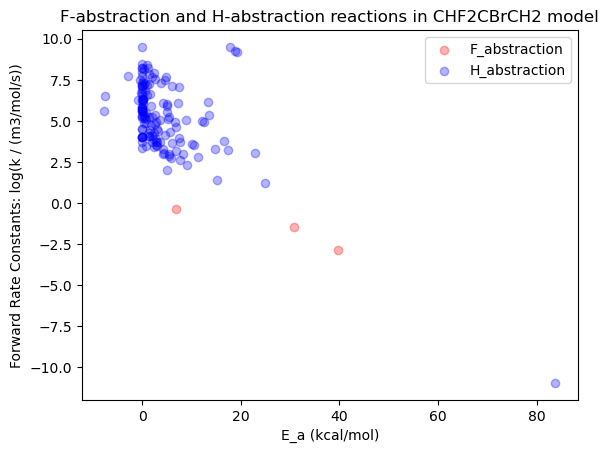

! Template reaction: F_Abstraction
! Flux pairs: CF2(43), CF(50); H(6), HF(38); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F]
! family: F_Abstraction
H(6)+CF2(43)=HF(38)+CF(50)                          1.085140e-36 14.363    6.864    


*******************************************************************************************************
HCFO-1233xf


Number of F_abstractions:     13 
Number of H_abstractions:     267 
Total reactions:              2051
F_abstraction percentage out of total reactions: 0.6 % 




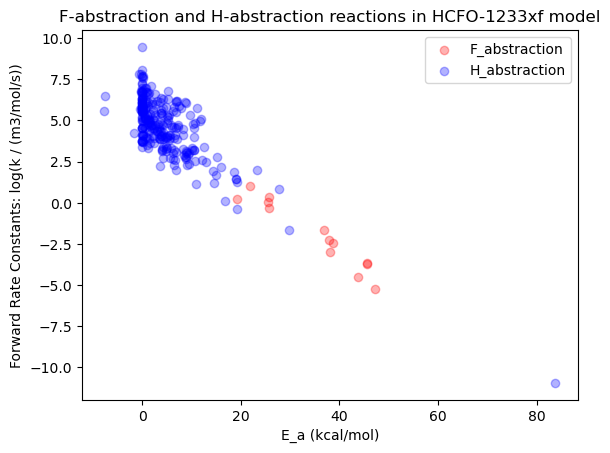

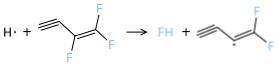

! Template reaction: F_Abstraction
! Flux pairs: S(13103), S(7376); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_Ext-1C-R
H(6)+S(13103)=HF(38)+S(7376)                        4.826740e-15 8.251     19.165   


*******************************************************************************************************
HFO-1234yf


Number of F_abstractions:     26 
Number of H_abstractions:     159 
Total reactions:              1374
F_abstraction percentage out of total reactions: 1.9 % 




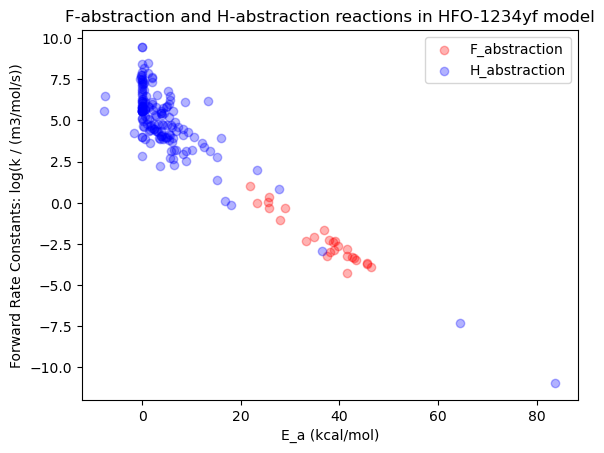

*******************************************************************************************************
HFO-1336mzz


Number of F_abstractions:     48 
Number of H_abstractions:     279 
Total reactions:              2404
F_abstraction percentage out of total reactions: 2.0 % 




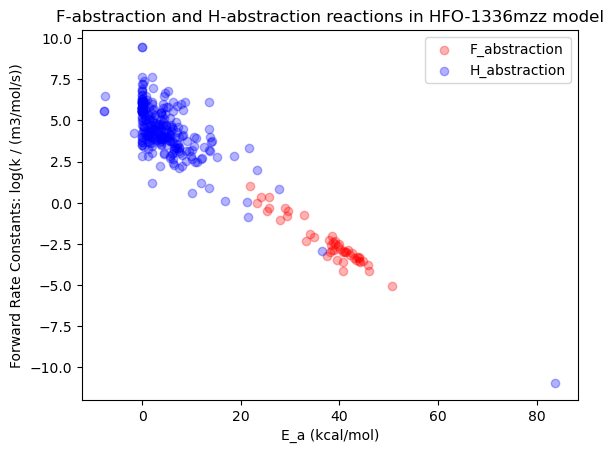

In [48]:
full_path = '/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/F_abs/DF_models/rmg_combustion_paper_FFCM/suppressants'
files_to_exclude = ['halomethanes']
get_Eas_rates(full_path, files_to_exclude, "Suppressants", T, P)

## Refrigerants 

Refrigerants
*******************************************************************************************************
C2H5F


Number of F_abstractions:     184 
Number of H_abstractions:     503 
Total reactions:              4409
F_abstraction percentage out of total reactions: 4.2 % 




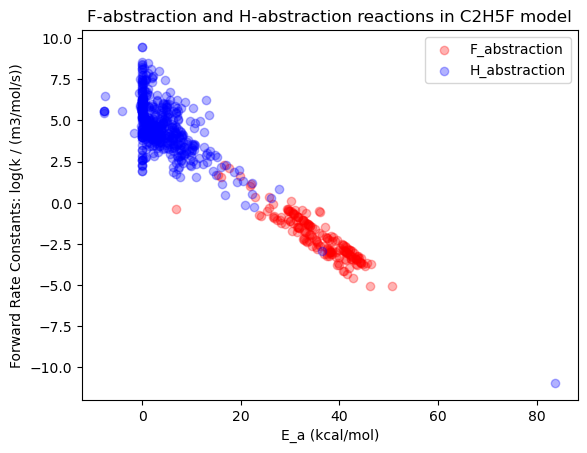

! Template reaction: F_Abstraction
! Flux pairs: S(1523), C2H2O(469); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(1523)=HF(38)+C2H2O(469)                      5.182650e-03 4.748     17.548   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(1521), HCCO(21); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(1521)=HF(38)+HCCO(21)                        1.575380e-09 6.622     16.047   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); CF2(43), CF(50); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule
! [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_3CClF->C_N-1CClH->C_Ext-3C-R_N-4R!H->Cl_N-4BrCFINOPSSi->C_N-4FO->O]
! family: F_Abstraction
H(6)+CF2(43)=HF(38)+CF(50)                          1.085140e-36 14.363    6.864    



! Template reaction: F_Abstraction
! Flux pairs: S(3093), S(2946); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F_Ext-1C-R_N-5R!H->F_5BrCClINOPSSi->C
! Multiplied by reaction path degeneracy 2.0
H(6)+S(3093)=HF(38)+S(2946)                         3.697300e-04 5.139     19.874   



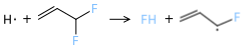

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(6353), C3H3(5302); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(6353)=HF(38)+C3H3(5302)                      1.575380e-09 6.622     15.378   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(5300), C3H3(5302); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(5300)=HF(38)+C3H3(5302)                      5.182650e-03 4.748     16.657   



*******************************************************************************************************
C2HF5


Number of F_abstractions:     88 
Number of H_abstractions:     48 
Total reactions:              799
F_abstraction percentage out of total reactions: 11.0 % 




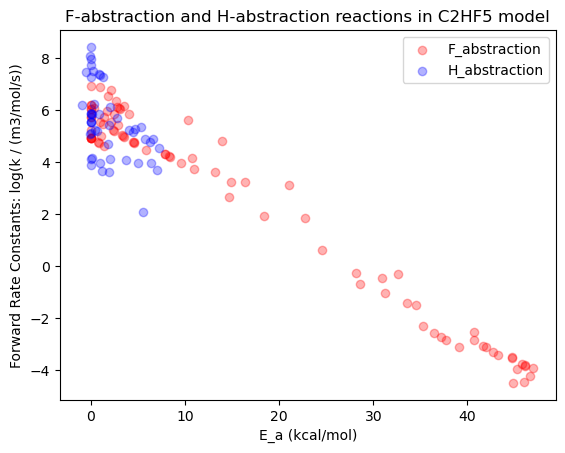

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(1); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(126)+C2HF4(54)=O2(2)+C2HF5(1)                   6.826940e+00 3.642     1.237    



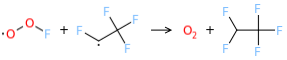

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(1); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(126)+C2HF4(69)=O2(2)+C2HF5(1)                   6.826940e+00 3.642     0.000    



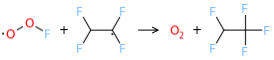

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO2(126)+H(6)=O2(2)+HF(38)                          1.041050e+06 2.314     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CF2O2(140), CF3O2(148); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(126)+CF2O2(140)=O2(2)+CF3O2(148)                9.788150e+01 3.351     0.000    



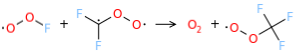

! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CHF3(42); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(126)+CHF2(81)=O2(2)+CHF3(42)                    1.198820e+01 3.287     0.000    



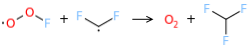

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(126)+CFO(51)=O2(2)+CF2O(49)                     1.198820e+01 3.287     0.000    



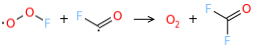

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(126)+CF3(45)=O2(2)+CF4(44)                      1.198820e+01 3.287     0.000    



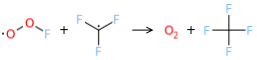

! Template reaction: F_Abstraction
! Flux pairs: C2F5(125), C2F6(53); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(126)+C2F5(125)=O2(2)+C2F6(53)                   6.826940e+00 3.642     0.000    



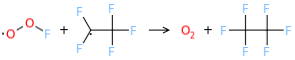

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(207), CHF3O(213); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(126)+CHF2O(207)=O2(2)+CHF3O(213)                9.788150e+01 3.351     0.000    



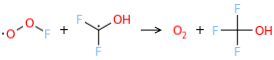

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(1); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(271)+C2HF4(54)=O(7)+C2HF5(1)                     6.826940e+00 3.642     5.844    



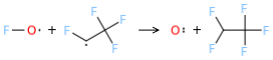

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(1); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(271)+C2HF4(69)=O(7)+C2HF5(1)                     6.826940e+00 3.642     4.450    



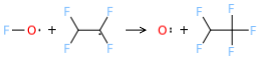

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO(271)+H(6)=O(7)+HF(38)                            1.041050e+06 2.314     3.550    



! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CHF3(42); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(271)+CHF2(81)=O(7)+CHF3(42)                      8.855870e+04 2.371     8.444    



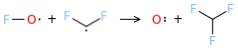

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(271)+CFO(51)=O(7)+CF2O(49)                       8.855870e+04 2.371     9.620    



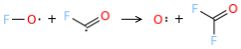

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(271)+CF3(45)=O(7)+CF4(44)                        8.855870e+04 2.371     7.900    



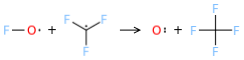

! Template reaction: F_Abstraction
! Flux pairs: C2F5(125), C2F6(53); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(271)+C2F5(125)=O(7)+C2F6(53)                     6.826940e+00 3.642     4.613    



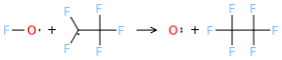

! Template reaction: F_Abstraction
! Flux pairs: CF2O2(140), CF3O2(148); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(271)+CF2O2(140)=O(7)+CF3O2(148)                  8.855870e+04 2.371     7.865    



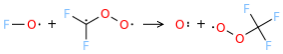

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(207), CHF3O(213); FO(271), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(271)+CHF2O(207)=O(7)+CHF3O(213)                  8.855870e+04 2.371     8.304    



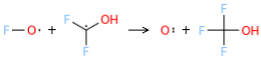

! Template reaction: F_Abstraction
! Flux pairs: FO2(126), O2(2); O(7), FO(271); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
O(7)+FO2(126)=FO(271)+O2(2)                         1.233330e+05 2.473     10.715   



! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(1); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2HF4(54)=F(37)+C2HF5(1)                     5.300000e+12 0.000     4.020    



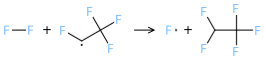

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(1); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2HF4(69)=F(37)+C2HF5(1)                     5.300000e+12 0.000     2.963    



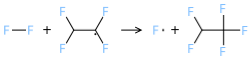

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); F2(78), F(37); 
! Fitted to 50 data points; dA = *|/ 1.09714, dn = +|- 0.0121793, dEa = +|- 0.066279 kJ/molMatched reaction 52 F2 + H <=> HF + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_N-1CClH->C_3ClF->F]
! family: F_Abstraction
F2(78)+H(6)=F(37)+HF(38)                            5.872910e+10 0.786     0.975    



! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); F2(78), F(37); 
! Fitted to 50 data points; dA = *|/ 1.07704, dn = +|- 0.00975049, dEa = +|- 0.0530618 kJ/molMatched reaction 67 F2 + CFO <=> CF2O + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_4R!H->O]
! family: F_Abstraction
F2(78)+CFO(51)=F(37)+CF2O(49)                       9.337540e+03 2.741     0.381    



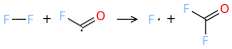

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); F2(78), F(37); 
! Matched reaction 0 F2 + CF3 <=> CF4_p23 + F_p1 in F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_N-4R!H->O]
! family: F_Abstraction
F2(78)+CF3(45)=F(37)+CF4(44)                        2.650000e+12 0.000     2.500    



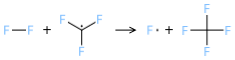

! Template reaction: F_Abstraction
! Flux pairs: C2F5(125), C2F6(53); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2F5(125)=F(37)+C2F6(53)                     5.300000e+12 0.000     3.085    



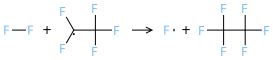

! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CHF3(42); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CHF2(81)=F(37)+CHF3(42)                      5.300000e+12 0.000     2.786    



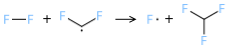

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(207), CHF3O(213); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CHF2O(207)=F(37)+CHF3O(213)                  9.690860e+03 2.746     0.000    



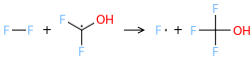

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(271); F2(78), F(37); 
! Estimated from node Root_N-1R->O_3R->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+O(7)=F(37)+FO(271)                           7.611020e-02 4.416     10.969   



! Template reaction: F_Abstraction
! Flux pairs: CF2O2(140), CF3O2(148); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CF2O2(140)=F(37)+CF3O2(148)                  9.690860e+03 2.746     0.000    



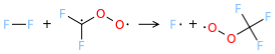

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); CF4O(295), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
H(6)+CF4O(295)=HF(38)+CF3O(48)                      1.041050e+06 2.314     2.660    



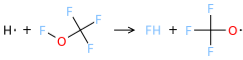

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); CF4O(295), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CFO(51)+CF4O(295)=CF2O(49)+CF3O(48)                 1.198820e+01 3.287     1.422    



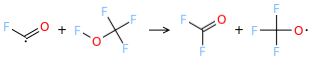

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); CF4O(295), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CF3(45)+CF4O(295)=CF4(44)+CF3O(48)                  1.198820e+01 3.287     0.837    



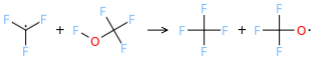

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(1); CF4O(295), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
CF4O(295)+C2HF4(54)=CF3O(48)+C2HF5(1)               6.826940e+00 3.642     4.545    



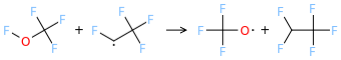

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(1); CF4O(295), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
CF4O(295)+C2HF4(69)=CF3O(48)+C2HF5(1)               6.826940e+00 3.642     3.379    



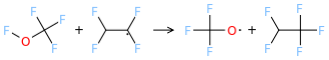

! Template reaction: F_Abstraction
! Flux pairs: C2F5(125), C2F6(53); CF4O(295), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
CF4O(295)+C2F5(125)=CF3O(48)+C2F6(53)               6.826940e+00 3.642     3.514    



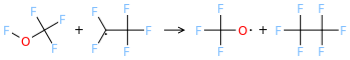

! Template reaction: F_Abstraction
! Flux pairs: F2(78), F(37); CF3O(48), CF4O(295); 
! Estimated from node Root_N-1R->O_3R->O_Ext-3O-R_4R!H->C
! Multiplied by reaction path degeneracy 2.0
F2(78)+CF3O(48)=F(37)+CF4O(295)                     2.961440e-02 4.468     14.690   



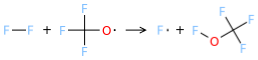

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(271); CF4O(295), CF3O(48); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_Ext-4R!H-R
O(7)+CF4O(295)=FO(271)+CF3O(48)                     4.875350e+04 3.062     13.873   



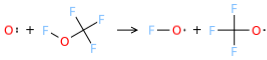

! Template reaction: F_Abstraction
! Flux pairs: CF3O(48), CF4O(295); FO2(126), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
FO2(126)+CF3O(48)=O2(2)+CF4O(295)                   1.233330e+05 2.473     13.137   



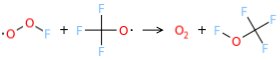

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(207), CHF3O(213); CF4O(295), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
CF4O(295)+CHF2O(207)=CF3O(48)+CHF3O(213)            9.788150e+01 3.351     2.153    



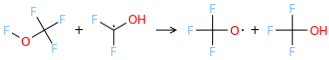

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FOF(297), FO(271); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
! Multiplied by reaction path degeneracy 2.0
FOF(297)+H(6)=FO(271)+HF(38)                        2.082100e+06 2.314     2.166    



! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FOF(297), FO(271); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
! Multiplied by reaction path degeneracy 2.0
FOF(297)+CFO(51)=FO(271)+CF2O(49)                   2.397640e+01 3.287     1.036    



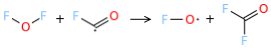

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FOF(297), FO(271); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
! Multiplied by reaction path degeneracy 2.0
FOF(297)+CF3(45)=FO(271)+CF4(44)                    2.397640e+01 3.287     0.000    



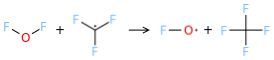

! Template reaction: F_Abstraction
! Flux pairs: C2F5(125), C2F6(53); FOF(297), FO(271); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FOF(297)+C2F5(125)=FO(271)+C2F6(53)                 1.365388e+01 3.642     2.899    



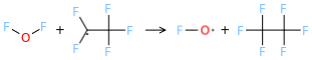

! Template reaction: F_Abstraction
! Flux pairs: F2(78), F(37); FO(271), FOF(297); 
! Estimated from node Root_N-1R->O_3R->O_Ext-3O-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+FO(271)=F(37)+FOF(297)                       8.526700e-02 4.351     18.436   



! Template reaction: F_Abstraction
! Flux pairs: FO(271), FOF(297); FO2(126), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
FO(271)+FO2(126)=FOF(297)+O2(2)                     1.233330e+05 2.473     14.891   



! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(1); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(1292)+C2HF4(54)=CFO2(260)+C2HF5(1)                6.826940e+00 3.642     3.293    



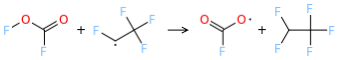

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(1); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(1292)+C2HF4(69)=CFO2(260)+C2HF5(1)                6.826940e+00 3.642     2.368    



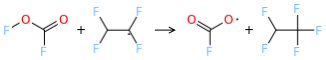

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
H(6)+S(1292)=HF(38)+CFO2(260)                       1.041050e+06 2.314     1.828    



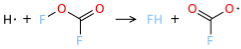

! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CHF3(42); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
S(1292)+CHF2(81)=CFO2(260)+CHF3(42)                 1.198820e+01 3.287     0.000    



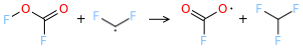

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CFO(51)+S(1292)=CF2O(49)+CFO2(260)                  1.198820e+01 3.287     0.789    



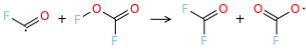

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CF3(45)+S(1292)=CF4(44)+CFO2(260)                   1.198820e+01 3.287     0.000    



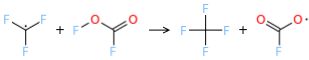

! Template reaction: F_Abstraction
! Flux pairs: C2F5(125), C2F6(53); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(1292)+C2F5(125)=CFO2(260)+C2F6(53)                6.826940e+00 3.642     2.474    



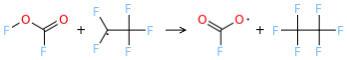

! Template reaction: F_Abstraction
! Flux pairs: CFO2(260), S(1292); FO2(126), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
! Multiplied by reaction path degeneracy 2.0
FO2(126)+CFO2(260)=O2(2)+S(1292)                    2.466660e+05 2.473     16.348   



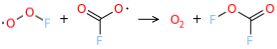

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(207), CHF3O(213); FOF(297), FO(271); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
! Multiplied by reaction path degeneracy 2.0
FOF(297)+CHF2O(207)=FO(271)+CHF3O(213)              1.957630e+02 3.351     1.692    



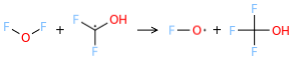

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(271); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_Ext-4R!H-R
O(7)+S(1292)=FO(271)+CFO2(260)                      4.875350e+04 3.062     10.303   



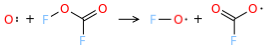

! Template reaction: F_Abstraction
! Flux pairs: S(128), S(160); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(126)+S(128)=O2(2)+S(160)                        6.826940e+00 3.642     1.016    



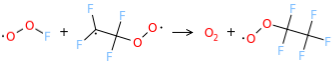

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(207), CHF3O(213); S(1292), CFO2(260); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
S(1292)+CHF2O(207)=CFO2(260)+CHF3O(213)             9.788150e+01 3.351     1.383    



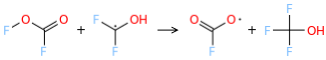

*******************************************************************************************************
C3F7H


Number of F_abstractions:     189 
Number of H_abstractions:     52 
Total reactions:              1544
F_abstraction percentage out of total reactions: 12.2 % 




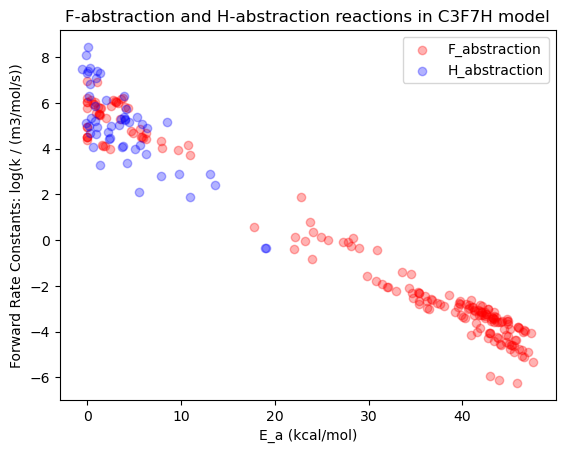

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); C3F7H(1), C3HF6(126); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_Ext-1C-R
H(6)+C3F7H(1)=HF(38)+C3HF6(126)                     4.826740e-15 8.251     17.770   



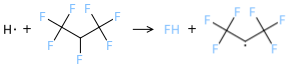

! Template reaction: F_Abstraction
! Flux pairs: C3HF6(126), C3F7H(1); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(131)+C3HF6(126)=O2(2)+C3F7H(1)                  6.826940e+00 3.642     2.019    



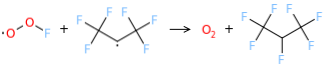

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO2(131)+H(6)=O2(2)+HF(38)                          1.041050e+06 2.314     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C3F5(132), C3F6(130); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FO2(131)+C3F5(132)=O2(2)+C3F6(130)                  1.365388e+01 3.642     1.149    



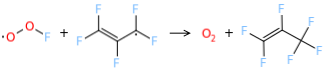

! Template reaction: F_Abstraction
! Flux pairs: C3F5(133), C3F6(130); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(131)+C3F5(133)=O2(2)+C3F6(130)                  6.826940e+00 3.642     1.192    



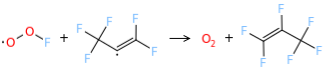

! Template reaction: F_Abstraction
! Flux pairs: C3F5(134), C3F6(130); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_N-Sp-4BrCFINOPSSi-3C
FO2(131)+C3F5(134)=O2(2)+C3F6(130)                  1.719080e+01 3.598     3.449    



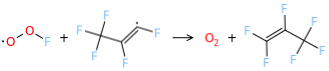

! Template reaction: F_Abstraction
! Flux pairs: C3F7(128), C3F8(175); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(131)+C3F7(128)=O2(2)+C3F8(175)                  6.826940e+00 3.642     1.373    



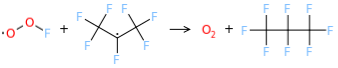

! Template reaction: F_Abstraction
! Flux pairs: C3F7(141), C3F8(175); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(131)+C3F7(141)=O2(2)+C3F8(175)                  6.826940e+00 3.642     0.930    



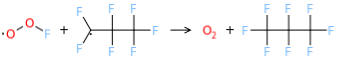

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(131)+CF3(45)=O2(2)+CF4(44)                      1.198820e+01 3.287     0.000    



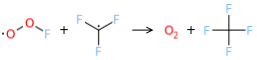

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(131)+CF3CO(74)=O2(2)+CF3COF(77)                 6.826940e+00 3.642     1.223    



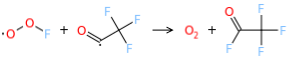

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(131)+CFO(51)=O2(2)+CF2O(49)                     1.198820e+01 3.287     0.000    



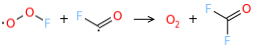

! Template reaction: F_Abstraction
! Flux pairs: S(1085), C3F5O(263); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FO2(131)+S(1085)=O2(2)+C3F5O(263)                   1.365388e+01 3.642     1.369    



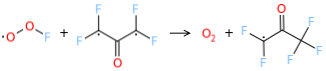

! Template reaction: F_Abstraction
! Flux pairs: C2F5(196), C2F6(53); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(131)+C2F5(196)=O2(2)+C2F6(53)                   6.826940e+00 3.642     0.000    



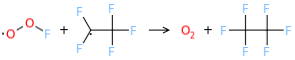

! Template reaction: F_Abstraction
! Flux pairs: C3HF6(126), C3F7H(1); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(785)+C3HF6(126)=O(7)+C3F7H(1)                    6.826940e+00 3.642     7.957    



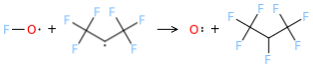

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO(785)+H(6)=O(7)+HF(38)                            1.041050e+06 2.314     3.550    



! Template reaction: F_Abstraction
! Flux pairs: C3F5(132), C3F6(130); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FO(785)+C3F5(132)=O(7)+C3F6(130)                    1.365388e+01 3.642     5.586    



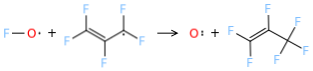

! Template reaction: F_Abstraction
! Flux pairs: C3F5(133), C3F6(130); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(785)+C3F5(133)=O(7)+C3F6(130)                    6.826940e+00 3.642     5.713    



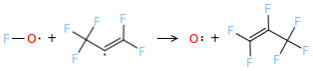

! Template reaction: F_Abstraction
! Flux pairs: C3F5(134), C3F6(130); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(785)+C3F5(134)=O(7)+C3F6(130)                    1.969830e+01 3.066     1.829    



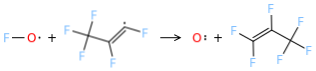

! Template reaction: F_Abstraction
! Flux pairs: C3F7(128), C3F8(175); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(785)+C3F7(128)=O(7)+C3F8(175)                    6.826940e+00 3.642     6.234    



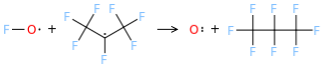

! Template reaction: F_Abstraction
! Flux pairs: C3F7(141), C3F8(175); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(785)+C3F7(141)=O(7)+C3F8(175)                    6.826940e+00 3.642     4.920    



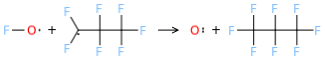

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(785)+CF3(45)=O(7)+CF4(44)                        8.855870e+04 2.371     7.900    



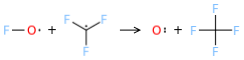

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(785)+CF3CO(74)=O(7)+CF3COF(77)                   6.826940e+00 3.642     5.805    



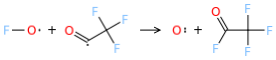

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(785)+CFO(51)=O(7)+CF2O(49)                       8.855870e+04 2.371     9.620    



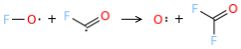

! Template reaction: F_Abstraction
! Flux pairs: S(1085), C3F5O(263); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FO(785)+S(1085)=O(7)+C3F5O(263)                     1.365388e+01 3.642     6.222    



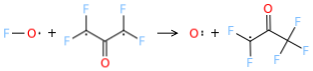

! Template reaction: F_Abstraction
! Flux pairs: C2F5(196), C2F6(53); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(785)+C2F5(196)=O(7)+C2F6(53)                     6.826940e+00 3.642     4.613    



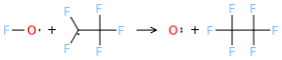

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(785); FO2(131), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
O(7)+FO2(131)=FO(785)+O2(2)                         1.233330e+05 2.473     10.715   



! Template reaction: F_Abstraction
! Flux pairs: C3HF6(126), C3F7H(1); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+C3HF6(126)=F(37)+C3F7H(1)                    2.233560e+03 2.918     1.507    



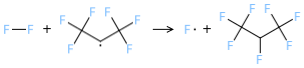

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); F2(78), F(37); 
! Fitted to 50 data points; dA = *|/ 1.09714, dn = +|- 0.0121793, dEa = +|- 0.066279 kJ/molMatched reaction 52 F2 + H <=> HF + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_N-1CClH->C_3ClF->F]
! family: F_Abstraction
F2(78)+H(6)=F(37)+HF(38)                            5.872910e+10 0.786     0.975    



! Template reaction: F_Abstraction
! Flux pairs: C3F5(132), C3F6(130); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 4.0
F2(78)+C3F5(132)=F(37)+C3F6(130)                    1.060000e+13 0.000     3.823    



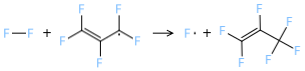

! Template reaction: F_Abstraction
! Flux pairs: C3F5(133), C3F6(130); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+C3F5(133)=F(37)+C3F6(130)                    2.233560e+03 2.918     0.698    



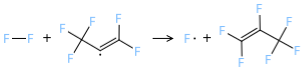

! Template reaction: F_Abstraction
! Flux pairs: C3F5(134), C3F6(130); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C3F5(134)=F(37)+C3F6(130)                    5.300000e+12 0.000     3.062    



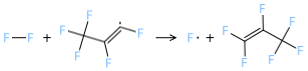

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); F2(78), F(37); 
! Matched reaction 0 F2 + CF3 <=> CF4_p23 + F_p1 in F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_N-4R!H->O]
! family: F_Abstraction
F2(78)+CF3(45)=F(37)+CF4(44)                        2.650000e+12 0.000     2.500    



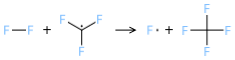

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CF3CO(74)=F(37)+CF3COF(77)                   9.690860e+03 2.746     0.849    



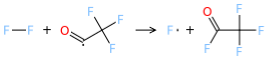

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); F2(78), F(37); 
! Fitted to 50 data points; dA = *|/ 1.07704, dn = +|- 0.00975049, dEa = +|- 0.0530618 kJ/molMatched reaction 67 F2 + CFO <=> CF2O + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_4R!H->O]
! family: F_Abstraction
F2(78)+CFO(51)=F(37)+CF2O(49)                       9.337540e+03 2.741     0.381    



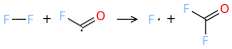

! Template reaction: F_Abstraction
! Flux pairs: C3F7(128), C3F8(175); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C3F7(128)=F(37)+C3F8(175)                    5.300000e+12 0.000     4.319    



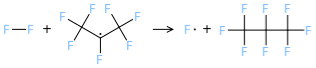

! Template reaction: F_Abstraction
! Flux pairs: C3F7(141), C3F8(175); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C3F7(141)=F(37)+C3F8(175)                    5.300000e+12 0.000     3.317    



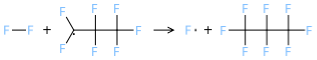

! Template reaction: F_Abstraction
! Flux pairs: C2F5(196), C2F6(53); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2F5(196)=F(37)+C2F6(53)                     5.300000e+12 0.000     3.085    



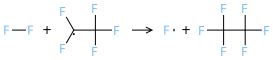

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(785); F2(78), F(37); 
! Estimated from node Root_N-1R->O_3R->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+O(7)=F(37)+FO(785)                           7.611020e-02 4.416     10.969   



! Template reaction: F_Abstraction
! Flux pairs: CHF2O(411), CHF3O(421); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(131)+CHF2O(411)=O2(2)+CHF3O(421)                9.788150e+01 3.351     0.000    



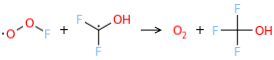

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(411), CHF3O(421); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CHF2O(411)=F(37)+CHF3O(421)                  9.690860e+03 2.746     0.000    



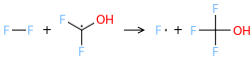

! Template reaction: F_Abstraction
! Flux pairs: C2F3(135), CF2CF2(61); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(131)+C2F3(135)=O2(2)+CF2CF2(61)                 1.969830e+01 3.066     0.000    



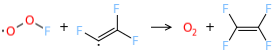

! Template reaction: F_Abstraction
! Flux pairs: C2F3(135), CF2CF2(61); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(785)+C2F3(135)=O(7)+CF2CF2(61)                   1.969830e+01 3.066     1.697    



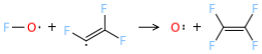

! Template reaction: F_Abstraction
! Flux pairs: C2F3(135), CF2CF2(61); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2F3(135)=F(37)+CF2CF2(61)                   5.300000e+12 0.000     2.906    



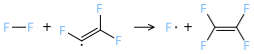

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(406), CF3COF(77); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(131)+C2F3O(406)=O2(2)+CF3COF(77)                6.826940e+00 3.642     1.251    



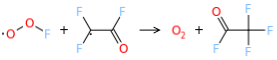

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(406), CF3COF(77); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(785)+C2F3O(406)=O(7)+CF3COF(77)                  6.826940e+00 3.642     5.885    



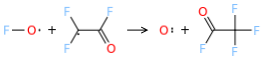

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(406), CF3COF(77); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2F3O(406)=F(37)+CF3COF(77)                  5.300000e+12 0.000     4.051    



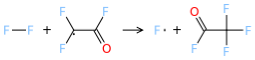

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(131)+CF2CH(73)=O2(2)+CHFCF2(55)                 1.969830e+01 3.066     0.000    



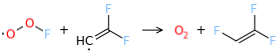

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(785)+CF2CH(73)=O(7)+CHFCF2(55)                   1.969830e+01 3.066     2.411    



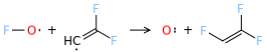

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+CF2CH(73)=F(37)+CHFCF2(55)                   2.233560e+03 2.918     0.622    



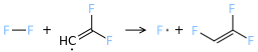

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(131)+C2HF2(72)=O2(2)+CHFCF2(55)                 1.969830e+01 3.066     0.000    



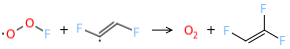

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO(785), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(785)+C2HF2(72)=O(7)+CHFCF2(55)                   1.969830e+01 3.066     1.574    



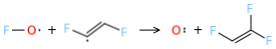

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2HF2(72)=F(37)+CHFCF2(55)                   5.300000e+12 0.000     2.758    



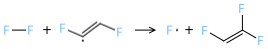

! Template reaction: F_Abstraction
! Flux pairs: S(2231), CF3CHO(75); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(131)+S(2231)=O2(2)+CF3CHO(75)                   2.856550e+00 3.303     0.000    



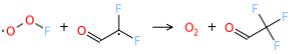

! Template reaction: F_Abstraction
! Flux pairs: CHO2(1368), S(3082); FO2(131), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(131)+CHO2(1368)=O2(2)+S(3082)                   9.788150e+01 3.351     0.000    



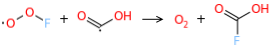

*******************************************************************************************************
CF3CH2F


Number of F_abstractions:     456 
Number of H_abstractions:     288 
Total reactions:              4182
F_abstraction percentage out of total reactions: 10.9 % 




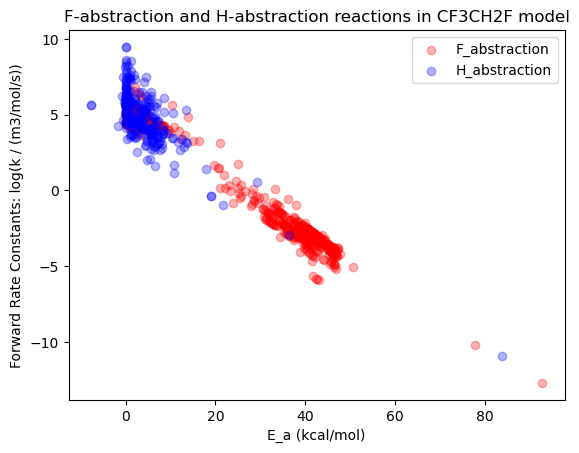

! Template reaction: F_Abstraction
! Flux pairs: S(126), CF3CH2F(1); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(127)+S(126)=O2(2)+CF3CH2F(1)                    6.826940e+00 3.642     1.817    



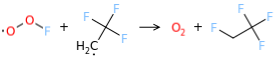

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), CF3CH2F(1); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(127)+C2H2F3(68)=O2(2)+CF3CH2F(1)                2.856550e+00 3.303     0.000    



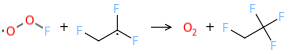

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO2(127)+H(6)=O2(2)+HF(38)                          1.041050e+06 2.314     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(127)+CF2CH(73)=O2(2)+CHFCF2(55)                 1.969830e+01 3.066     0.000    



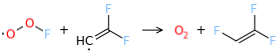

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(127)+C2HF2(72)=O2(2)+CHFCF2(55)                 1.969830e+01 3.066     0.000    



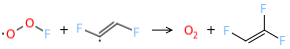

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(127)+CFO(51)=O2(2)+CF2O(49)                     1.198820e+01 3.287     0.000    



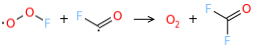

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
FO2(127)+HCO(15)=O2(2)+CHFO(47)                     2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(65), S(620); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R_Ext-3C-R
FO2(127)+C2H3F2(65)=O2(2)+S(620)                    9.363340e+02 3.099     0.000    



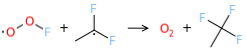

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(127)+C2HF4(54)=O2(2)+C2HF5(81)                  6.826940e+00 3.642     1.237    



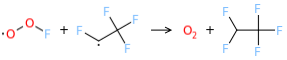

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(127)+C2HF4(69)=O2(2)+C2HF5(81)                  6.826940e+00 3.642     0.000    



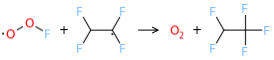

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(182), CF3COF(77); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(127)+C2F3O(182)=O2(2)+CF3COF(77)                6.826940e+00 3.642     1.251    



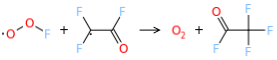

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(127)+CHF2(82)=O2(2)+CHF3(42)                    1.198820e+01 3.287     0.000    



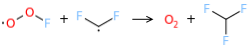

! Template reaction: F_Abstraction
! Flux pairs: CF2O2(171), CF3O2(640); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(127)+CF2O2(171)=O2(2)+CF3O2(640)                9.788150e+01 3.351     0.000    



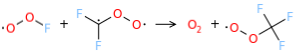

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(127)+CF3(45)=O2(2)+CF4(44)                      1.198820e+01 3.287     0.000    



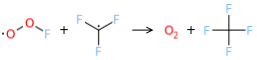

! Template reaction: F_Abstraction
! Flux pairs: CH2F(46), CH2F2(41); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(127)+CH2F(46)=O2(2)+CH2F2(41)                   1.198820e+01 3.287     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2F3(128), CF2CF2(61); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(127)+C2F3(128)=O2(2)+CF2CF2(61)                 1.969830e+01 3.066     0.000    



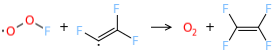

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(205), CHF3O(216); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(127)+CHF2O(205)=O2(2)+CHF3O(216)                9.788150e+01 3.351     0.000    



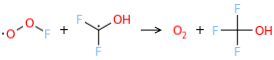

! Template reaction: F_Abstraction
! Flux pairs: C2F5(678), C2F6(53); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(127)+C2F5(678)=O2(2)+C2F6(53)                   6.826940e+00 3.642     0.000    



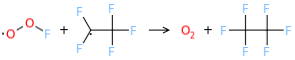

! Template reaction: F_Abstraction
! Flux pairs: CHO2(863), S(2030); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(127)+CHO2(863)=O2(2)+S(2030)                    9.788150e+01 3.351     0.000    



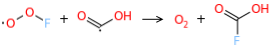

! Template reaction: F_Abstraction
! Flux pairs: S(126), CF3CH2F(1); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(378)+S(126)=O(7)+CF3CH2F(1)                      6.826940e+00 3.642     7.435    



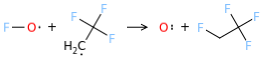

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), CF3CH2F(1); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(378)+C2H2F3(68)=O(7)+CF3CH2F(1)                  2.856550e+00 3.303     1.291    



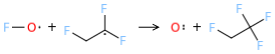

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO(378)+H(6)=O(7)+HF(38)                            1.041050e+06 2.314     3.550    



! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(378)+CF2CH(73)=O(7)+CHFCF2(55)                   1.969830e+01 3.066     2.411    



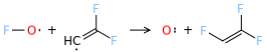

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(378)+C2HF2(72)=O(7)+CHFCF2(55)                   1.969830e+01 3.066     1.574    



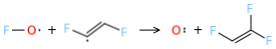

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(378)+CFO(51)=O(7)+CF2O(49)                       8.855870e+04 2.371     9.620    



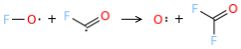

! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(65), S(620); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(378)+C2H3F2(65)=O(7)+S(620)                      8.855870e+04 2.371     8.435    



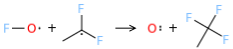

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(378)+C2HF4(54)=O(7)+C2HF5(81)                    6.826940e+00 3.642     5.844    



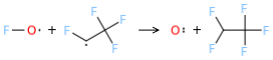

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(378)+C2HF4(69)=O(7)+C2HF5(81)                    6.826940e+00 3.642     4.450    



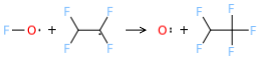

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(182), CF3COF(77); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(378)+C2F3O(182)=O(7)+CF3COF(77)                  6.826940e+00 3.642     5.885    



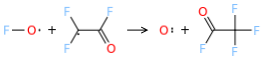

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(378)+CHF2(82)=O(7)+CHF3(42)                      8.855870e+04 2.371     8.444    



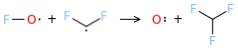

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(378)+CF3(45)=O(7)+CF4(44)                        8.855870e+04 2.371     7.900    



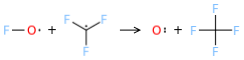

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(378)+HCO(15)=O(7)+CHFO(47)                       2.084580e+03 2.800     3.303    



! Template reaction: F_Abstraction
! Flux pairs: CH2F(46), CH2F2(41); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0
FO(378)+CH2F(46)=O(7)+CH2F2(41)                     4.321000e+02 2.927     4.719    



! Template reaction: F_Abstraction
! Flux pairs: C2F3(128), CF2CF2(61); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(378)+C2F3(128)=O(7)+CF2CF2(61)                   1.969830e+01 3.066     1.697    



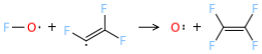

! Template reaction: F_Abstraction
! Flux pairs: C2F5(678), C2F6(53); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(378)+C2F5(678)=O(7)+C2F6(53)                     6.826940e+00 3.642     4.613    



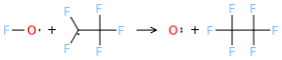

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(378); FO2(127), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
O(7)+FO2(127)=FO(378)+O2(2)                         1.233330e+05 2.473     10.715   



! Template reaction: F_Abstraction
! Flux pairs: CH2(T)(18), CH2F(46); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_N-3C-u1_1O-u0_Ext-1O-R
FO2(127)+CH2(T)(18)=O2(2)+CH2F(46)                  1.786980e+02 3.259     1.094    



! Template reaction: F_Abstraction
! Flux pairs: CH2(T)(18), CH2F(46); FO(378), O(7); 
! Fitted to 50 data points; dA = *|/ 1.22333, dn = +|- 0.0264834, dEa = +|- 0.144122 kJ/molMatched reaction 87 [O]F_r12 + CH2 <=> [CH2]F_r12 + [O]_r3 in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_3R->O_N-1BrCClFHINPSSi-u0_N-3O-u1]
! family: F_Abstraction
FO(378)+CH2(T)(18)=O(7)+CH2F(46)                    9.967950e+02 2.978     9.855    



! Template reaction: F_Abstraction
! Flux pairs: S(1265), S(426); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(127)+S(1265)=O2(2)+S(426)                       2.856550e+00 3.303     0.000    



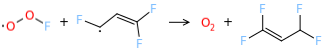

! Template reaction: F_Abstraction
! Flux pairs: S(1265), S(426); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(378)+S(1265)=O(7)+S(426)                         2.856550e+00 3.303     3.396    



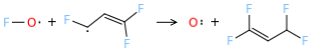

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(127)+CF3CO(74)=O2(2)+CF3COF(77)                 6.826940e+00 3.642     1.223    



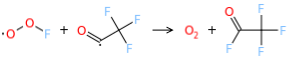

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(378)+CF3CO(74)=O(7)+CF3COF(77)                   6.826940e+00 3.642     5.805    



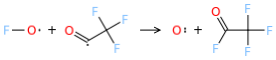

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(205), CHF3O(216); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(378)+CHF2O(205)=O(7)+CHF3O(216)                  8.855870e+04 2.371     8.304    



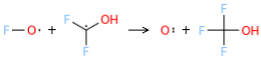

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
H(6)+CF4O(365)=HF(38)+CF3O(48)                      1.041050e+06 2.314     2.660    



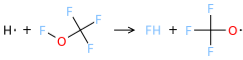

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CFO(51)+CF4O(365)=CF2O(49)+CF3O(48)                 1.198820e+01 3.287     1.422    



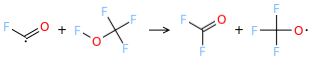

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(182), CF3COF(77); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
CF4O(365)+C2F3O(182)=CF3O(48)+CF3COF(77)            6.826940e+00 3.642     4.579    



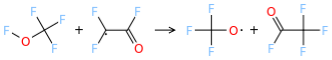

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
CF4O(365)+CF3CO(74)=CF3O(48)+CF3COF(77)             6.826940e+00 3.642     4.512    



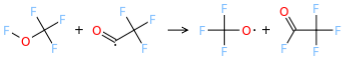

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CF3(45)+CF4O(365)=CF4(44)+CF3O(48)                  1.198820e+01 3.287     0.837    



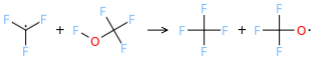

! Template reaction: F_Abstraction
! Flux pairs: CF3O(48), CF4O(365); FO2(127), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
FO2(127)+CF3O(48)=O2(2)+CF4O(365)                   1.233330e+05 2.473     13.137   



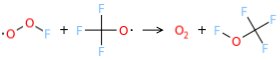

! Template reaction: F_Abstraction
! Flux pairs: CH(17), CHF(40); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO2(127)+CH(17)=O2(2)+CHF(40)                       3.982760e+06 1.789     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CH(17), CHF(40); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO(378)+CH(17)=O(7)+CHF(40)                         3.982760e+06 1.789     4.614    



! Template reaction: F_Abstraction
! Flux pairs: S(2123), S(546); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(127)+S(2123)=O2(2)+S(546)                       6.826940e+00 3.642     1.361    



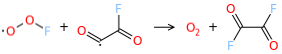

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(378); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_Ext-4R!H-R
O(7)+CF4O(365)=FO(378)+CF3O(48)                     4.875350e+04 3.062     13.873   



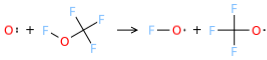

! Template reaction: F_Abstraction
! Flux pairs: S(126), CF3CH2F(1); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(8222)+S(126)=CFO2(280)+CF3CH2F(1)                 6.826940e+00 3.642     4.389    



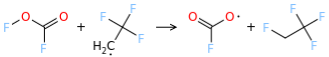

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), CF3CH2F(1); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
S(8222)+C2H2F3(68)=CFO2(280)+CF3CH2F(1)             2.856550e+00 3.303     0.000    



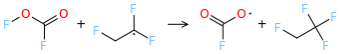

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
H(6)+S(8222)=HF(38)+CFO2(280)                       1.041050e+06 2.314     1.828    



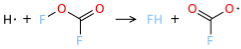

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
S(8222)+CF2CH(73)=CFO2(280)+CHFCF2(55)              1.969830e+01 3.066     0.911    



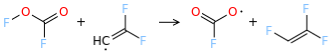

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
S(8222)+C2HF2(72)=CFO2(280)+CHFCF2(55)              1.969830e+01 3.066     0.000    



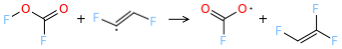

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CFO(51)+S(8222)=CF2O(49)+CFO2(280)                  1.198820e+01 3.287     0.789    



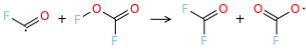

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(8222)+C2HF4(54)=CFO2(280)+C2HF5(81)               6.826940e+00 3.642     3.293    



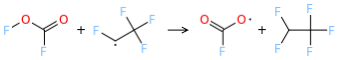

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(8222)+C2HF4(69)=CFO2(280)+C2HF5(81)               6.826940e+00 3.642     2.368    



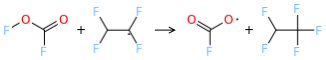

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(182), CF3COF(77); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(8222)+C2F3O(182)=CFO2(280)+CF3COF(77)             6.826940e+00 3.642     3.320    



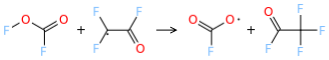

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(8222)+CF3CO(74)=CFO2(280)+CF3COF(77)              6.826940e+00 3.642     3.266    



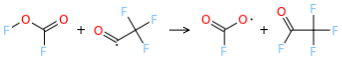

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CF3(45)+S(8222)=CF4(44)+CFO2(280)                   1.198820e+01 3.287     0.000    



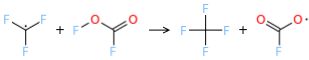

! Template reaction: F_Abstraction
! Flux pairs: C2F5(678), C2F6(53); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
S(8222)+C2F5(678)=CFO2(280)+C2F6(53)                6.826940e+00 3.642     2.474    



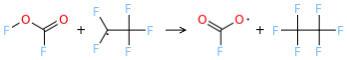

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
S(8222)+CHF2(82)=CFO2(280)+CHF3(42)                 1.198820e+01 3.287     0.000    



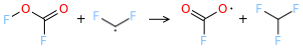

! Template reaction: F_Abstraction
! Flux pairs: CFO2(280), S(8222); FO2(127), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
! Multiplied by reaction path degeneracy 2.0
FO2(127)+CFO2(280)=O2(2)+S(8222)                    2.466660e+05 2.473     16.348   



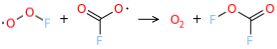

! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(39); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO2(127)+CH3(19)=O2(2)+CH3F(39)                     3.982760e+06 1.789     1.858    



! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(378); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_Ext-4R!H-R
O(7)+S(8222)=FO(378)+CFO2(280)                      4.875350e+04 3.062     10.303   



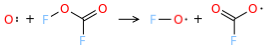

! Template reaction: F_Abstraction
! Flux pairs: S(126), CF3CH2F(1); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FOF(367)+S(126)=FO(378)+CF3CH2F(1)                  1.365388e+01 3.642     5.012    



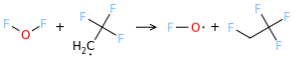

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), CF3CH2F(1); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
! Multiplied by reaction path degeneracy 2.0
FOF(367)+C2H2F3(68)=FO(378)+CF3CH2F(1)              5.713100e+00 3.303     0.000    



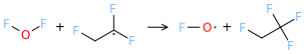

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
! Multiplied by reaction path degeneracy 2.0
FOF(367)+H(6)=FO(378)+HF(38)                        2.082100e+06 2.314     2.166    



! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FOF(367)+CF2CH(73)=FO(378)+CHFCF2(55)               3.939660e+01 3.066     1.183    



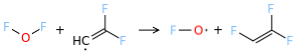

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FOF(367)+C2HF2(72)=FO(378)+CHFCF2(55)               3.939660e+01 3.066     0.678    



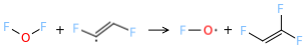

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
! Multiplied by reaction path degeneracy 2.0
FOF(367)+CFO(51)=FO(378)+CF2O(49)                   2.397640e+01 3.287     1.036    



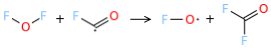

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(182), CF3COF(77); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FOF(367)+C2F3O(182)=FO(378)+CF3COF(77)              1.365388e+01 3.642     3.838    



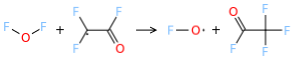

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FOF(367)+CF3CO(74)=FO(378)+CF3COF(77)               1.365388e+01 3.642     3.778    



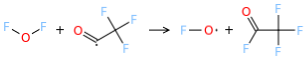

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
! Multiplied by reaction path degeneracy 2.0
FOF(367)+CF3(45)=FO(378)+CF4(44)                    2.397640e+01 3.287     0.000    



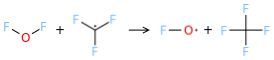

! Template reaction: F_Abstraction
! Flux pairs: C2F5(678), C2F6(53); FOF(367), FO(378); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FOF(367)+C2F5(678)=FO(378)+C2F6(53)                 1.365388e+01 3.642     2.899    



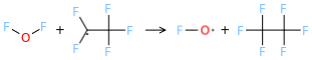

! Template reaction: F_Abstraction
! Flux pairs: FO(378), FOF(367); FO2(127), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
FO(378)+FO2(127)=FOF(367)+O2(2)                     1.233330e+05 2.473     14.891   



! Template reaction: F_Abstraction
! Flux pairs: CHF2O(205), CHF3O(216); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
CF4O(365)+CHF2O(205)=CF3O(48)+CHF3O(216)            9.788150e+01 3.351     2.153    



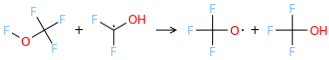

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(205), CHF3O(216); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
S(8222)+CHF2O(205)=CFO2(280)+CHF3O(216)             9.788150e+01 3.351     1.383    



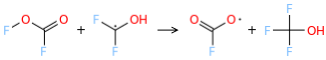

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
CF4O(365)+HCO(15)=CF3O(48)+CHFO(47)                 2.677620e-01 3.934     0.000    



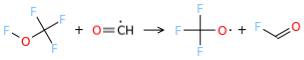

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); CF2CO(76), C2FO(1156); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F_Ext-1C-R_N-5R!H->F_5BrCClINOPSSi->C
! Multiplied by reaction path degeneracy 2.0
H(6)+CF2CO(76)=HF(38)+C2FO(1156)                    3.697300e-04 5.139     19.573   



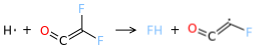

! Template reaction: F_Abstraction
! Flux pairs: S(126), CF3CH2F(1); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(405)+S(126)=OH(4)+CF3CH2F(1)                     6.826940e+00 3.642     6.663    



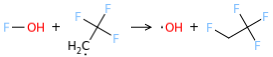

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), CF3CH2F(1); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(405)+C2H2F3(68)=OH(4)+CF3CH2F(1)                 2.856550e+00 3.303     1.004    



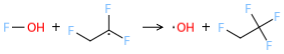

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
H(6)+OF(405)=HF(38)+OH(4)                           1.041050e+06 2.314     3.098    



! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(405)+CF2CH(73)=OH(4)+CHFCF2(55)                  1.969830e+01 3.066     1.993    



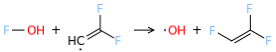

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(405)+C2HF2(72)=OH(4)+CHFCF2(55)                  1.969830e+01 3.066     1.262    



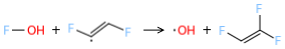

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(405)+CFO(51)=OH(4)+CF2O(49)                      1.198820e+01 3.287     1.783    



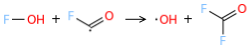

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
OF(405)+HCO(15)=OH(4)+CHFO(47)                      2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(65), S(620); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R_Ext-3C-R
OF(405)+C2H3F2(65)=OH(4)+S(620)                     9.363340e+02 3.099     0.000    



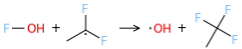

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(405)+C2HF4(54)=OH(4)+C2HF5(81)                   6.826940e+00 3.642     5.189    



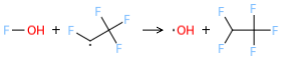

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(405)+C2HF4(69)=OH(4)+C2HF5(81)                   6.826940e+00 3.642     3.908    



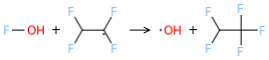

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(182), CF3COF(77); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(405)+C2F3O(182)=OH(4)+CF3COF(77)                 6.826940e+00 3.642     5.227    



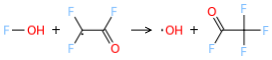

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(405)+CF3CO(74)=OH(4)+CF3COF(77)                  6.826940e+00 3.642     5.153    



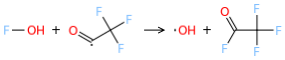

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(405)+CHF2(82)=OH(4)+CHF3(42)                     1.198820e+01 3.287     1.299    



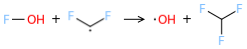

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(405)+CF3(45)=OH(4)+CF4(44)                       1.198820e+01 3.287     1.096    



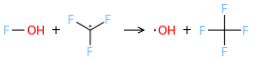

! Template reaction: F_Abstraction
! Flux pairs: CH2F(46), CH2F2(41); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(405)+CH2F(46)=OH(4)+CH2F2(41)                    1.198820e+01 3.287     1.986    



! Template reaction: F_Abstraction
! Flux pairs: C2F3(128), CF2CF2(61); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(405)+C2F3(128)=OH(4)+CF2CF2(61)                  1.969830e+01 3.066     1.368    



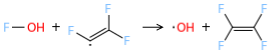

! Template reaction: F_Abstraction
! Flux pairs: CF2O2(171), CF3O2(640); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
OF(405)+CF2O2(171)=OH(4)+CF3O2(640)                 9.788150e+01 3.351     2.334    



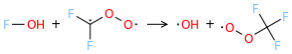

! Template reaction: F_Abstraction
! Flux pairs: C2F5(678), C2F6(53); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(405)+C2F5(678)=OH(4)+C2F6(53)                    6.826940e+00 3.642     4.057    



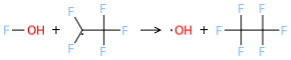

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(205), CHF3O(216); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
OF(405)+CHF2O(205)=OH(4)+CHF3O(216)                 9.788150e+01 3.351     2.570    



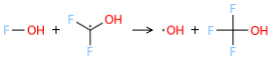

! Template reaction: F_Abstraction
! Flux pairs: S(1265), S(426); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(405)+S(1265)=OH(4)+S(426)                        2.856550e+00 3.303     2.845    



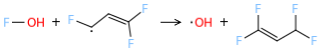

! Template reaction: F_Abstraction
! Flux pairs: CH(17), CHF(40); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
OF(405)+CH(17)=OH(4)+CHF(40)                        3.982760e+06 1.789     4.065    



! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(39); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
OF(405)+CH3(19)=OH(4)+CH3F(39)                      3.982760e+06 1.789     6.672    



! Template reaction: F_Abstraction
! Flux pairs: OH(4), OF(405); FO2(127), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
FO2(127)+OH(4)=O2(2)+OF(405)                        1.233330e+05 2.473     11.848   



! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); CF4O(365), CF3O(48); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
CF4O(365)+CHF2(82)=CF3O(48)+CHF3(42)                1.198820e+01 3.287     1.008    



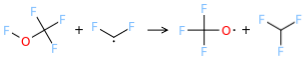

! Template reaction: F_Abstraction
! Flux pairs: CHO2(863), S(2030); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(378)+CHO2(863)=O(7)+S(2030)                      8.855870e+04 2.371     9.399    



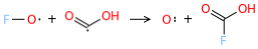

! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R
FO2(127)+CH2CF(70)=O2(2)+CH2CF2(57)                 5.462980e+01 3.310     0.000    



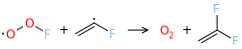

! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R
OF(405)+CH2CF(70)=OH(4)+CH2CF2(57)                  5.462980e+01 3.310     0.000    



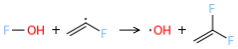

! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(378)+CH2CF(70)=O(7)+CH2CF2(57)                   8.855870e+04 2.371     8.098    



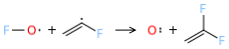

! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); S(8222), CFO2(280); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R
S(8222)+CH2CF(70)=CFO2(280)+CH2CF2(57)              5.462980e+01 3.310     0.000    



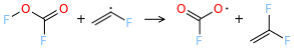

! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(127)+C2H2F(71)=O2(2)+C2H2F2(59)                 1.969830e+01 3.066     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(405)+C2H2F(71)=OH(4)+C2H2F2(59)                  1.969830e+01 3.066     2.087    



! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(378)+C2H2F(71)=O(7)+C2H2F2(59)                   1.969830e+01 3.066     2.517    



! Template reaction: F_Abstraction
! Flux pairs: C2F(2147), C2F2(60); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(127)+C2F(2147)=O2(2)+C2F2(60)                   1.969830e+01 3.066     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2F(2147), C2F2(60); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(405)+C2F(2147)=OH(4)+C2F2(60)                    1.969830e+01 3.066     1.551    



! Template reaction: F_Abstraction
! Flux pairs: C2F(2147), C2F2(60); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(378)+C2F(2147)=O(7)+C2F2(60)                     1.969830e+01 3.066     1.907    



! Template reaction: F_Abstraction
! Flux pairs: CFO2(1329), CF2O2(191); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(127)+CFO2(1329)=O2(2)+CF2O2(191)                1.198820e+01 3.287     0.000    



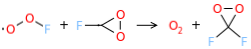

! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(39); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO(378)+CH3(19)=O(7)+CH3F(39)                       3.982760e+06 1.789     7.436    



! Template reaction: F_Abstraction
! Flux pairs: C2H(22), C2HF(58); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO2(127)+C2H(22)=O2(2)+C2HF(58)                     1.259270e+03 2.989     4.748    



! Template reaction: F_Abstraction
! Flux pairs: C2H(22), C2HF(58); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(378)+C2H(22)=O(7)+C2HF(58)                       1.259270e+03 2.989     12.229   



! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(56); FO2(127), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_N-Sp-4BrCFINOPSSi-3C
FO2(127)+C2H3(29)=O2(2)+CH2CHF(56)                  9.414390e+00 3.584     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(56); OF(405), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_N-Sp-4BrCFINOPSSi-3C
OF(405)+C2H3(29)=OH(4)+CH2CHF(56)                   9.414390e+00 3.584     2.614    



! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(56); FO(378), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(378)+C2H3(29)=O(7)+CH2CHF(56)                    2.084580e+03 2.800     2.921    



*******************************************************************************************************
CF3CHCH2


Number of F_abstractions:     14 
Number of H_abstractions:     69 
Total reactions:              1043
F_abstraction percentage out of total reactions: 1.3 % 




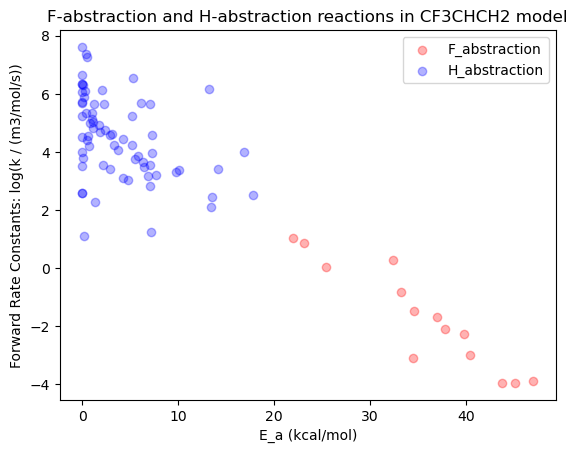

*******************************************************************************************************
CF3H


Number of F_abstractions:     40 
Number of H_abstractions:     24 
Total reactions:              423
F_abstraction percentage out of total reactions: 9.5 % 




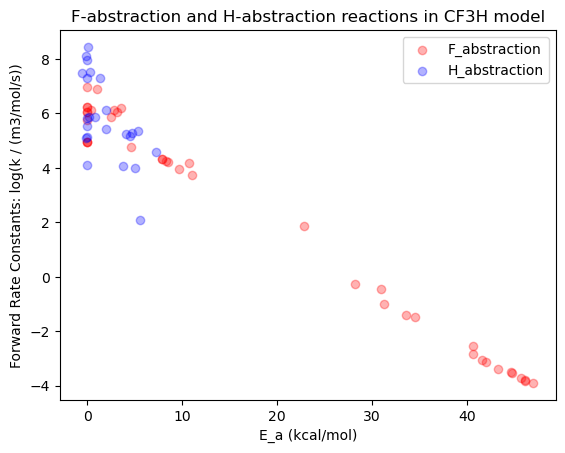

! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CF3H(1); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CHF2(81)=O2(2)+CF3H(1)                     1.198820e+01 3.287     0.000    



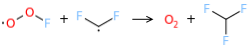

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO2(124)+H(6)=O2(2)+HF(38)                          1.041050e+06 2.314     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CFO(50), CF2O(48); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CFO(50)=O2(2)+CF2O(48)                     1.198820e+01 3.287     0.000    



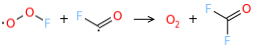

! Template reaction: F_Abstraction
! Flux pairs: CF2O2(125), CF3O2(175); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(124)+CF2O2(125)=O2(2)+CF3O2(175)                9.788150e+01 3.351     0.000    



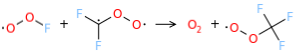

! Template reaction: F_Abstraction
! Flux pairs: CF3(44), CF4(43); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CF3(44)=O2(2)+CF4(43)                      1.198820e+01 3.287     0.000    



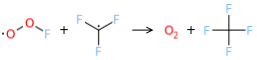

! Template reaction: F_Abstraction
! Flux pairs: C2F5(177), C2F6(52); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(124)+C2F5(177)=O2(2)+C2F6(52)                   6.826940e+00 3.642     0.000    



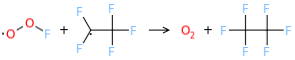

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(155), CHF3O(159); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(124)+CHF2O(155)=O2(2)+CHF3O(159)                9.788150e+01 3.351     0.000    



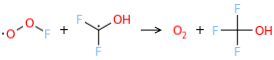

! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CF3H(1); FO(154), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(154)+CHF2(81)=O(7)+CF3H(1)                       8.855870e+04 2.371     8.444    



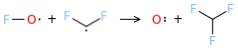

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO(154), O(7); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO(154)+H(6)=O(7)+HF(38)                            1.041050e+06 2.314     3.550    



! Template reaction: F_Abstraction
! Flux pairs: CFO(50), CF2O(48); FO(154), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(154)+CFO(50)=O(7)+CF2O(48)                       8.855870e+04 2.371     9.620    



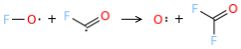

! Template reaction: F_Abstraction
! Flux pairs: CF2O2(125), CF3O2(175); FO(154), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(154)+CF2O2(125)=O(7)+CF3O2(175)                  8.855870e+04 2.371     7.865    



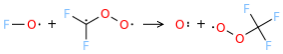

! Template reaction: F_Abstraction
! Flux pairs: CF3(44), CF4(43); FO(154), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(154)+CF3(44)=O(7)+CF4(43)                        8.855870e+04 2.371     7.900    



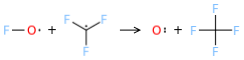

! Template reaction: F_Abstraction
! Flux pairs: C2F5(177), C2F6(52); FO(154), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(154)+C2F5(177)=O(7)+C2F6(52)                     6.826940e+00 3.642     4.613    



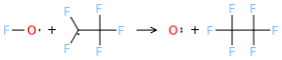

! Template reaction: F_Abstraction
! Flux pairs: FO2(124), O2(2); O(7), FO(154); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
O(7)+FO2(124)=FO(154)+O2(2)                         1.233330e+05 2.473     10.715   



! Template reaction: F_Abstraction
! Flux pairs: CHF2O(155), CHF3O(159); FO(154), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(154)+CHF2O(155)=O(7)+CHF3O(159)                  8.855870e+04 2.371     8.304    



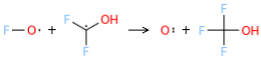

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); F2(77), F(37); 
! Fitted to 50 data points; dA = *|/ 1.09714, dn = +|- 0.0121793, dEa = +|- 0.066279 kJ/molMatched reaction 52 F2 + H <=> HF + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_N-1CClH->C_3ClF->F]
! family: F_Abstraction
F2(77)+H(6)=F(37)+HF(38)                            5.872910e+10 0.786     0.975    



! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CF3H(1); F2(77), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(77)+CHF2(81)=F(37)+CF3H(1)                       5.300000e+12 0.000     2.786    



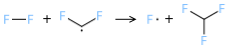

! Template reaction: F_Abstraction
! Flux pairs: CFO(50), CF2O(48); F2(77), F(37); 
! Fitted to 50 data points; dA = *|/ 1.07704, dn = +|- 0.00975049, dEa = +|- 0.0530618 kJ/molMatched reaction 67 F2 + CFO <=> CF2O + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_4R!H->O]
! family: F_Abstraction
F2(77)+CFO(50)=F(37)+CF2O(48)                       9.337540e+03 2.741     0.381    



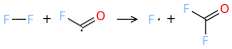

! Template reaction: F_Abstraction
! Flux pairs: CF3(44), CF4(43); F2(77), F(37); 
! Matched reaction 0 F2 + CF3 <=> CF4_p23 + F_p1 in F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_N-4R!H->O]
! family: F_Abstraction
F2(77)+CF3(44)=F(37)+CF4(43)                        2.650000e+12 0.000     2.500    



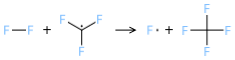

! Template reaction: F_Abstraction
! Flux pairs: C2F5(177), C2F6(52); F2(77), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(77)+C2F5(177)=F(37)+C2F6(52)                     5.300000e+12 0.000     3.085    



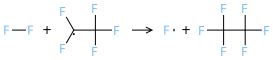

! Template reaction: F_Abstraction
! Flux pairs: CF2O2(125), CF3O2(175); F2(77), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(77)+CF2O2(125)=F(37)+CF3O2(175)                  9.690860e+03 2.746     0.000    



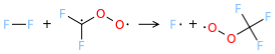

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(155), CHF3O(159); F2(77), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(77)+CHF2O(155)=F(37)+CHF3O(159)                  9.690860e+03 2.746     0.000    



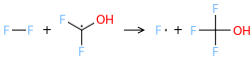

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(154); F2(77), F(37); 
! Estimated from node Root_N-1R->O_3R->O
! Multiplied by reaction path degeneracy 2.0
F2(77)+O(7)=F(37)+FO(154)                           7.611020e-02 4.416     10.969   



*******************************************************************************************************
CH2CFCHF2


Number of F_abstractions:     170 
Number of H_abstractions:     353 
Total reactions:              3473
F_abstraction percentage out of total reactions: 4.9 % 




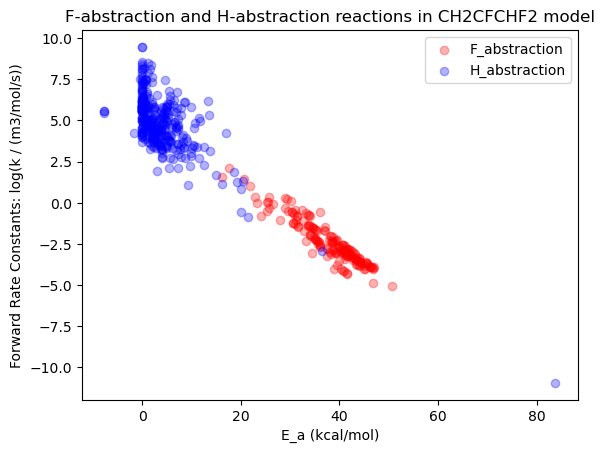

! Template reaction: F_Abstraction
! Flux pairs: S(401), S(2078); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(401)=HF(38)+S(2078)                          5.182650e-03 4.748     17.548   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(6069), C3HF2(710); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(6069)=HF(38)+C3HF2(710)                      1.575380e-09 6.622     16.092   



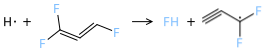

*******************************************************************************************************
CH2CHCH3


Number of F_abstractions:     0 
Number of H_abstractions:     1145 
Total reactions:              6956
F_abstraction percentage out of total reactions: 0.0 % 




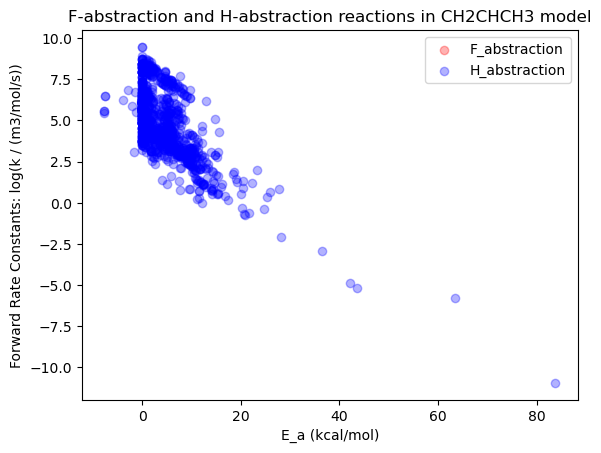

*******************************************************************************************************
CH2F2


Number of F_abstractions:     42 
Number of H_abstractions:     112 
Total reactions:              1082
F_abstraction percentage out of total reactions: 3.9 % 




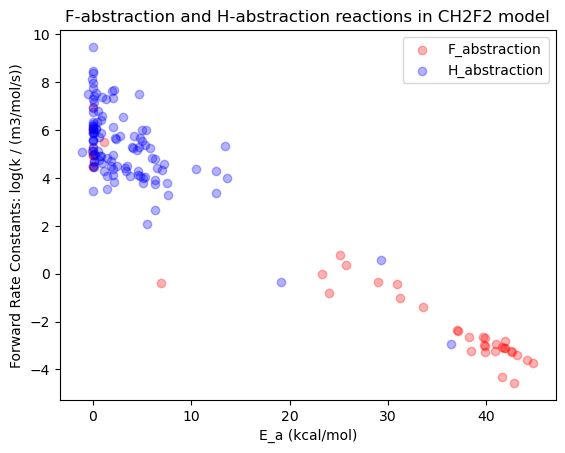

! Template reaction: F_Abstraction
! Flux pairs: CF2(42), CF(49); H(6), HF(38); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F]
! family: F_Abstraction
H(6)+CF2(42)=HF(38)+CF(49)                          1.085140e-36 14.363    6.864    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO2(124)+H(6)=O2(2)+HF(38)                          1.041050e+06 2.314     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CFO(50), CF2O(48); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CFO(50)=O2(2)+CF2O(48)                     1.198820e+01 3.287     0.000    



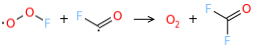

! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CHF3(41); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CHF2(81)=O2(2)+CHF3(41)                    1.198820e+01 3.287     0.000    



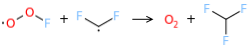

! Template reaction: F_Abstraction
! Flux pairs: CF(49), CF2(42); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CF(49)=O2(2)+CF2(42)                       1.198820e+01 3.287     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(66), S(187); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(124)+C2H2F3(66)=O2(2)+S(187)                    6.826940e+00 3.642     1.149    



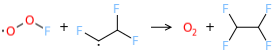

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(72), CHFCF2(54); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(124)+CF2CH(72)=O2(2)+CHFCF2(54)                 1.969830e+01 3.066     0.000    



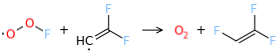

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(71), CHFCF2(54); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(124)+C2HF2(71)=O2(2)+CHFCF2(54)                 1.969830e+01 3.066     0.000    



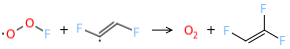

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(46); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
FO2(124)+HCO(15)=O2(2)+CHFO(46)                     2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CF2O2(173), CF3O2(562); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(124)+CF2O2(173)=O2(2)+CF3O2(562)                9.788150e+01 3.351     0.000    



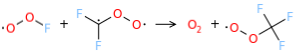

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(266), CHF3O(271); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(124)+CHF2O(266)=O2(2)+CHF3O(271)                9.788150e+01 3.351     0.000    



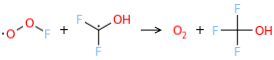

! Template reaction: F_Abstraction
! Flux pairs: CHO2(180), CHFO2(134); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(124)+CHO2(180)=O2(2)+CHFO2(134)                 9.788150e+01 3.351     0.000    



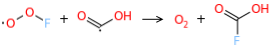

*******************************************************************************************************
CH2F2_YF_mix


Number of F_abstractions:     168 
Number of H_abstractions:     352 
Total reactions:              3518
F_abstraction percentage out of total reactions: 4.8 % 




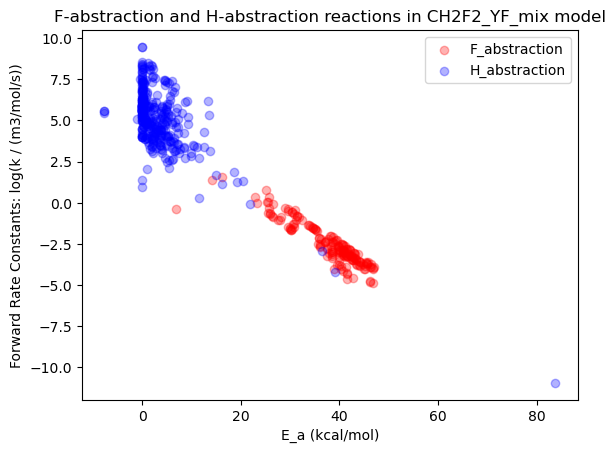

! Template reaction: F_Abstraction
! Flux pairs: H(5), HF(39); C3HF3(172), S(7917); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(5)+C3HF3(172)=HF(39)+S(7917)                      1.575380e-09 6.622     16.092   



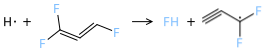

! Template reaction: F_Abstraction
! Flux pairs: H(5), HF(39); S(1385), S(2329); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_Ext-1C-R
H(5)+S(1385)=HF(39)+S(2329)                         4.826740e-15 8.251     14.124   



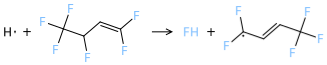

! Template reaction: F_Abstraction
! Flux pairs: CF2(43), CF(50); H(5), HF(39); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F]
! family: F_Abstraction
H(5)+CF2(43)=HF(39)+CF(50)                          1.085140e-36 14.363    6.864    



*******************************************************************************************************
CH2FCH2F


Number of F_abstractions:     278 
Number of H_abstractions:     500 
Total reactions:              5053
F_abstraction percentage out of total reactions: 5.5 % 




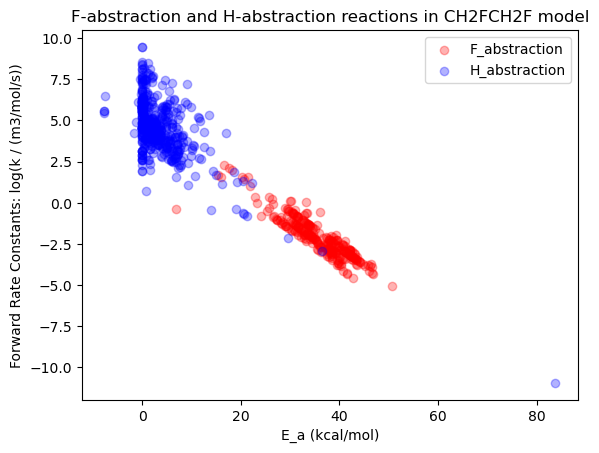

! Template reaction: F_Abstraction
! Flux pairs: S(187), C2H2O(341); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(187)=HF(38)+C2H2O(341)                       5.182650e-03 4.748     17.548   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(694), CH2CFO(79); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(694)=HF(38)+CH2CFO(79)                       5.182650e-03 4.748     18.124   



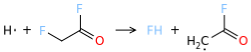

! Template reaction: F_Abstraction
! Flux pairs: CF2(43), CF(50); H(6), HF(38); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F]
! family: F_Abstraction
H(6)+CF2(43)=HF(38)+CF(50)                          1.085140e-36 14.363    6.864    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(1168), HCCO(21); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(1168)=HF(38)+HCCO(21)                        1.575380e-09 6.622     16.047   



! Template reaction: F_Abstraction
! Flux pairs: S(8713), C3H3(5003); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(8713)=HF(38)+C3H3(5003)                      1.575380e-09 6.622     15.378   



! Template reaction: F_Abstraction
! Flux pairs: S(5001), C3H3(5003); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(5001)=HF(38)+C3H3(5003)                      5.182650e-03 4.748     16.657   



*******************************************************************************************************
CH2FCHF2


Number of F_abstractions:     355 
Number of H_abstractions:     398 
Total reactions:              4704
F_abstraction percentage out of total reactions: 7.5 % 




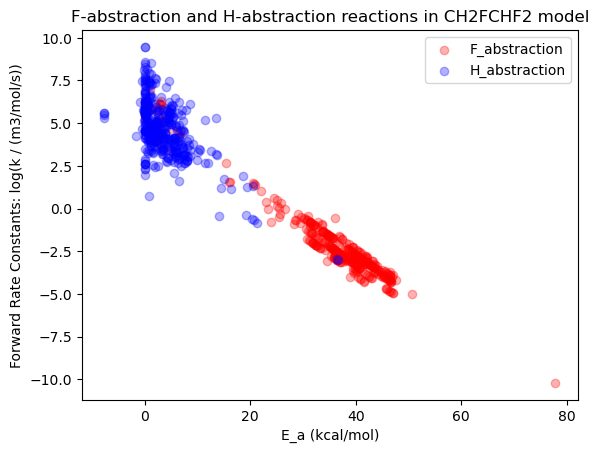

! Template reaction: F_Abstraction
! Flux pairs: S(3422), HCCO(21); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(3422)=HF(38)+HCCO(21)                        1.575380e-09 6.622     16.047   



! Template reaction: F_Abstraction
! Flux pairs: S(8725), S(9685); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(8725)=HF(38)+S(9685)                         1.575380e-09 6.622     16.092   



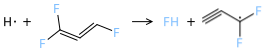

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); F2(78), F(37); 
! Fitted to 50 data points; dA = *|/ 1.09714, dn = +|- 0.0121793, dEa = +|- 0.066279 kJ/molMatched reaction 52 F2 + H <=> HF + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_N-1CClH->C_3ClF->F]
! family: F_Abstraction
F2(78)+H(6)=F(37)+HF(38)                            5.872910e+10 0.786     0.975    



! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2H2F(71)=F(37)+C2H2F2(59)                   2.233560e+03 2.918     0.668    



! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(64), C2H3F3(1); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2H3F2(64)=F(37)+C2H3F3(1)                   2.233560e+03 2.918     1.203    



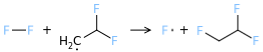

! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(66), C2H3F3(1); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2H3F2(66)=F(37)+C2H3F3(1)                   5.300000e+12 0.000     3.843    



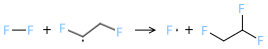

! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CH2CF(70)=F(37)+CH2CF2(57)                   5.300000e+12 0.000     2.603    



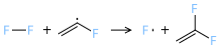

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); F2(78), F(37); 
! Fitted to 50 data points; dA = *|/ 1.07704, dn = +|- 0.00975049, dEa = +|- 0.0530618 kJ/molMatched reaction 67 F2 + CFO <=> CF2O + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_4R!H->O]
! family: F_Abstraction
F2(78)+CFO(51)=F(37)+CF2O(49)                       9.337540e+03 2.741     0.381    



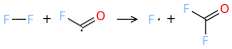

! Template reaction: F_Abstraction
! Flux pairs: S(131), S(7941); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+S(131)=F(37)+S(7941)                         2.233560e+03 2.918     1.299    



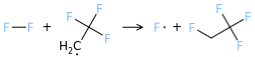

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), S(7941); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2H2F3(68)=F(37)+S(7941)                     5.300000e+12 0.000     2.985    



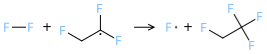

! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(65), S(147); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2H3F2(65)=F(37)+S(147)                      5.300000e+12 0.000     2.781    



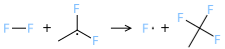

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); F2(78), F(37); 
! Matched reaction 0 F2 + CF3 <=> CF4_p23 + F_p1 in F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_N-4R!H->O]
! family: F_Abstraction
F2(78)+CF3(45)=F(37)+CF4(44)                        2.650000e+12 0.000     2.500    



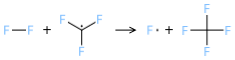

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CHF2(82)=F(37)+CHF3(42)                      5.300000e+12 0.000     2.786    



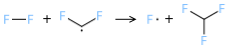

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+HCO(15)=F(37)+CHFO(47)                       9.690860e+03 2.746     0.630    



! Template reaction: F_Abstraction
! Flux pairs: CHO2(7915), S(3756); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CHO2(7915)=F(37)+S(3756)                     9.690860e+03 2.746     0.000    



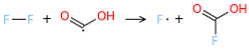

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
H(6)+OF(342)=HF(38)+OH(4)                           1.041050e+06 2.314     3.098    



! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(64), C2H3F3(1); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(342)+C2H3F2(64)=OH(4)+C2H3F3(1)                  6.826940e+00 3.642     6.428    



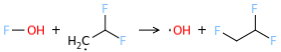

! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(66), C2H3F3(1); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(342)+C2H3F2(66)=OH(4)+C2H3F3(1)                  2.856550e+00 3.303     1.569    



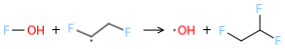

! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(342)+C2H2F(71)=OH(4)+C2H2F2(59)                  1.969830e+01 3.066     2.087    



! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R
OF(342)+CH2CF(70)=OH(4)+CH2CF2(57)                  5.462980e+01 3.310     0.000    



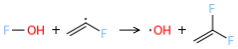

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
OF(342)+HCO(15)=OH(4)+CHFO(47)                      2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(342)+CFO(51)=OH(4)+CF2O(49)                      1.198820e+01 3.287     1.783    



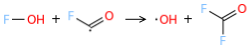

! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(65), S(147); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R_Ext-3C-R
OF(342)+C2H3F2(65)=OH(4)+S(147)                     9.363340e+02 3.099     0.000    



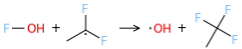

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(342)+CF2CH(73)=OH(4)+CHFCF2(55)                  1.969830e+01 3.066     1.993    



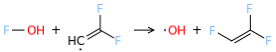

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(342)+C2HF2(72)=OH(4)+CHFCF2(55)                  1.969830e+01 3.066     1.262    



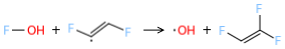

! Template reaction: F_Abstraction
! Flux pairs: S(131), S(7941); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(342)+S(131)=OH(4)+S(7941)                        6.826940e+00 3.642     6.663    



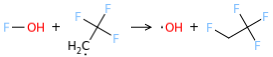

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), S(7941); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(342)+C2H2F3(68)=OH(4)+S(7941)                    2.856550e+00 3.303     1.004    



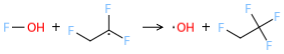

! Template reaction: F_Abstraction
! Flux pairs: CH2F(46), CH2F2(41); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(342)+CH2F(46)=OH(4)+CH2F2(41)                    1.198820e+01 3.287     1.986    



! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(342)+CHF2(82)=OH(4)+CHF3(42)                     1.198820e+01 3.287     1.299    



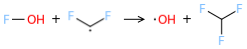

! Template reaction: F_Abstraction
! Flux pairs: HCCO(21), S(3422); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(342)+HCCO(21)=OH(4)+S(3422)                      1.969830e+01 3.066     4.791    



! Template reaction: F_Abstraction
! Flux pairs: S(9136), S(1070); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(342)+S(9136)=OH(4)+S(1070)                       2.856550e+00 3.303     2.845    



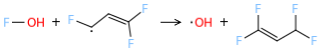

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(342)+CF3(45)=OH(4)+CF4(44)                       1.198820e+01 3.287     1.096    



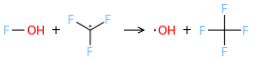

! Template reaction: F_Abstraction
! Flux pairs: S(9685), S(8725); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_N-Sp-4BrCFINOPSSi-3C
OF(342)+S(9685)=OH(4)+S(8725)                       1.719080e+01 3.598     15.349   



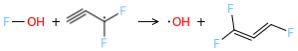

! Template reaction: F_Abstraction
! Flux pairs: S(9685), CF3CCH(84); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(342)+S(9685)=OH(4)+CF3CCH(84)                    2.856550e+00 3.303     1.603    



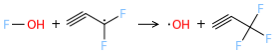

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(342)+C2HF4(54)=OH(4)+C2HF5(81)                   6.826940e+00 3.642     5.189    



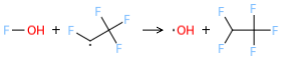

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(342)+C2HF4(69)=OH(4)+C2HF5(81)                   6.826940e+00 3.642     3.908    



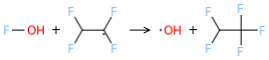

! Template reaction: F_Abstraction
! Flux pairs: S(9136), S(609); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(342)+S(9136)=OH(4)+S(609)                        2.856550e+00 3.303     1.701    



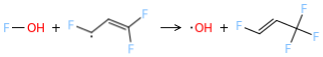

! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(56); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_N-Sp-4BrCFINOPSSi-3C
OF(342)+C2H3(29)=OH(4)+CH2CHF(56)                   9.414390e+00 3.584     2.614    



! Template reaction: F_Abstraction
! Flux pairs: CHF2O(767), CHF3O(610); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
OF(342)+CHF2O(767)=OH(4)+CHF3O(610)                 9.788150e+01 3.351     2.570    



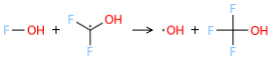

! Template reaction: F_Abstraction
! Flux pairs: CHO2(7915), S(3756); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
OF(342)+CHO2(7915)=OH(4)+S(3756)                    9.788150e+01 3.351     3.190    



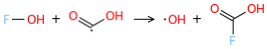

! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(39); OF(342), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
OF(342)+CH3(19)=OH(4)+CH3F(39)                      3.982760e+06 1.789     6.672    



*******************************************************************************************************
CH3CF3


Number of F_abstractions:     370 
Number of H_abstractions:     370 
Total reactions:              4164
F_abstraction percentage out of total reactions: 8.9 % 




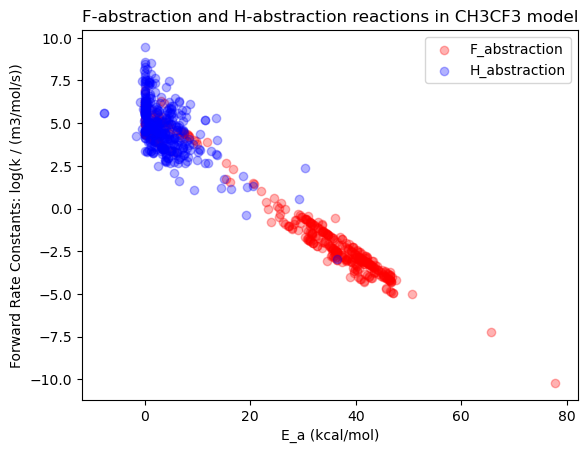

! Template reaction: F_Abstraction
! Flux pairs: S(1486), S(2532); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(1486)=HF(38)+S(2532)                         1.575380e-09 6.622     16.092   



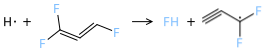

! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(65), CH3CF3(1); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R_Ext-3C-R
FO2(126)+C2H3F2(65)=O2(2)+CH3CF3(1)                 9.363340e+02 3.099     0.000    



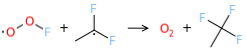

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO2(126)+H(6)=O2(2)+HF(38)                          1.041050e+06 2.314     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R
FO2(126)+CH2CF(70)=O2(2)+CH2CF2(57)                 5.462980e+01 3.310     0.000    



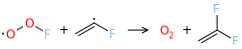

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(126)+CFO(51)=O2(2)+CF2O(49)                     1.198820e+01 3.287     0.000    



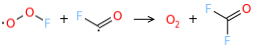

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(126)+CF2CH(73)=O2(2)+CHFCF2(55)                 1.969830e+01 3.066     0.000    



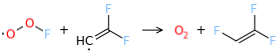

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(126)+C2HF2(72)=O2(2)+CHFCF2(55)                 1.969830e+01 3.066     0.000    



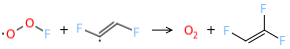

! Template reaction: F_Abstraction
! Flux pairs: S(125), S(739); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(126)+S(125)=O2(2)+S(739)                        6.826940e+00 3.642     1.817    



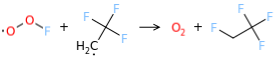

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), S(739); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(126)+C2H2F3(68)=O2(2)+S(739)                    2.856550e+00 3.303     0.000    



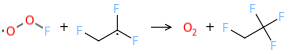

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(126)+CHF2(82)=O2(2)+CHF3(42)                    1.198820e+01 3.287     0.000    



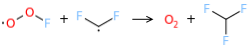

! Template reaction: F_Abstraction
! Flux pairs: S(130), S(751); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(126)+S(130)=O2(2)+S(751)                        6.826940e+00 3.642     2.071    



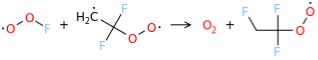

! Template reaction: F_Abstraction
! Flux pairs: S(1482), S(320); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(126)+S(1482)=O2(2)+S(320)                       2.856550e+00 3.303     0.000    



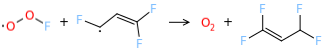

! Template reaction: F_Abstraction
! Flux pairs: CH2(T)(18), CH2F(46); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_N-3C-u1_1O-u0_Ext-1O-R
FO2(126)+CH2(T)(18)=O2(2)+CH2F(46)                  1.786980e+02 3.259     1.094    



! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
FO2(126)+HCO(15)=O2(2)+CHFO(47)                     2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: S(2532), S(1486); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_N-Sp-4BrCFINOPSSi-3C
FO2(126)+S(2532)=O2(2)+S(1486)                      1.719080e+01 3.598     7.013    



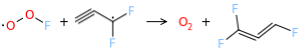

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(126)+C2HF4(54)=O2(2)+C2HF5(81)                  6.826940e+00 3.642     1.237    



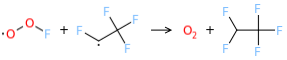

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(126)+C2HF4(69)=O2(2)+C2HF5(81)                  6.826940e+00 3.642     0.000    



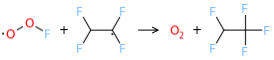

! Template reaction: F_Abstraction
! Flux pairs: CF2O2(162), CF3O2(750); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(126)+CF2O2(162)=O2(2)+CF3O2(750)                9.788150e+01 3.351     0.000    



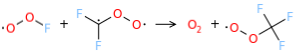

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(126)+CF3(45)=O2(2)+CF4(44)                      1.198820e+01 3.287     0.000    



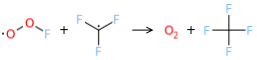

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(191), CHF3O(201); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(126)+CHF2O(191)=O2(2)+CHF3O(201)                9.788150e+01 3.351     0.000    



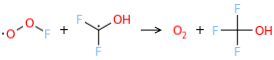

! Template reaction: F_Abstraction
! Flux pairs: CH2F(46), CH2F2(41); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(126)+CH2F(46)=O2(2)+CH2F2(41)                   1.198820e+01 3.287     0.000    



! Template reaction: F_Abstraction
! Flux pairs: S(2532), CF3CCH(84); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(126)+S(2532)=O2(2)+CF3CCH(84)                   2.856550e+00 3.303     0.000    



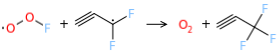

! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(126)+C2H2F(71)=O2(2)+C2H2F2(59)                 1.969830e+01 3.066     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CHO2(1070), S(1612); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(126)+CHO2(1070)=O2(2)+S(1612)                   9.788150e+01 3.351     0.000    



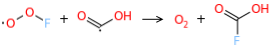

! Template reaction: F_Abstraction
! Flux pairs: CH(17), CHF(40); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO2(126)+CH(17)=O2(2)+CHF(40)                       3.982760e+06 1.789     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(39); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO2(126)+CH3(19)=O2(2)+CH3F(39)                     3.982760e+06 1.789     1.858    



! Template reaction: F_Abstraction
! Flux pairs: S(1482), S(1481); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(126)+S(1482)=O2(2)+S(1481)                      2.856550e+00 3.303     0.000    



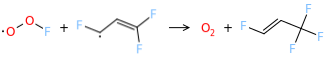

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(12371), C3H3(5898); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(12371)=HF(38)+C3H3(5898)                     1.575380e-09 6.622     15.378   



! Template reaction: F_Abstraction
! Flux pairs: C3H3(5898), S(12371); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_N-Sp-4BrCFINOPSSi-3C
FO2(126)+C3H3(5898)=O2(2)+S(12371)                  1.719080e+01 3.598     7.411    



! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(65), CH3CF3(1); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R_Ext-3C-R
OF(321)+C2H3F2(65)=OH(4)+CH3CF3(1)                  9.363340e+02 3.099     0.000    



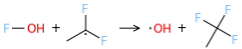

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
H(6)+OF(321)=HF(38)+OH(4)                           1.041050e+06 2.314     3.098    



! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Ext-3C-R
OF(321)+CH2CF(70)=OH(4)+CH2CF2(57)                  5.462980e+01 3.310     0.000    



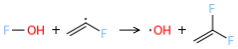

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(321)+CFO(51)=OH(4)+CF2O(49)                      1.198820e+01 3.287     1.783    



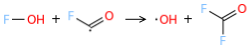

! Template reaction: F_Abstraction
! Flux pairs: S(125), S(739); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(321)+S(125)=OH(4)+S(739)                         6.826940e+00 3.642     6.663    



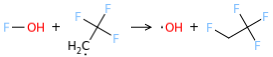

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), S(739); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(321)+C2H2F3(68)=OH(4)+S(739)                     2.856550e+00 3.303     1.004    



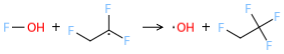

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(321)+CHF2(82)=OH(4)+CHF3(42)                     1.198820e+01 3.287     1.299    



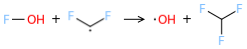

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(321)+CF2CH(73)=OH(4)+CHFCF2(55)                  1.969830e+01 3.066     1.993    



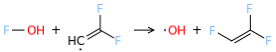

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(321)+C2HF2(72)=OH(4)+CHFCF2(55)                  1.969830e+01 3.066     1.262    



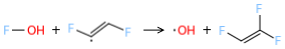

! Template reaction: F_Abstraction
! Flux pairs: S(1482), S(320); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(321)+S(1482)=OH(4)+S(320)                        2.856550e+00 3.303     2.845    



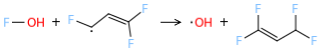

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
OF(321)+HCO(15)=OH(4)+CHFO(47)                      2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: S(2532), S(1486); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_N-Sp-4BrCFINOPSSi-3C
OF(321)+S(2532)=OH(4)+S(1486)                       1.719080e+01 3.598     15.349   



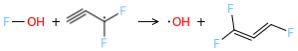

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(321)+C2HF4(54)=OH(4)+C2HF5(81)                   6.826940e+00 3.642     5.189    



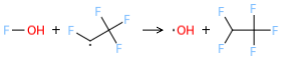

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
OF(321)+C2HF4(69)=OH(4)+C2HF5(81)                   6.826940e+00 3.642     3.908    



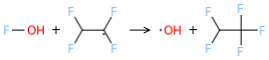

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(321)+CF3(45)=OH(4)+CF4(44)                       1.198820e+01 3.287     1.096    



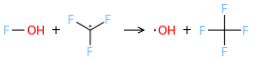

! Template reaction: F_Abstraction
! Flux pairs: CH2F(46), CH2F2(41); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(321)+CH2F(46)=OH(4)+CH2F2(41)                    1.198820e+01 3.287     1.986    



! Template reaction: F_Abstraction
! Flux pairs: S(2532), CF3CCH(84); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(321)+S(2532)=OH(4)+CF3CCH(84)                    2.856550e+00 3.303     1.603    



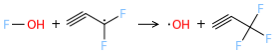

! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
OF(321)+C2H2F(71)=OH(4)+C2H2F2(59)                  1.969830e+01 3.066     2.087    



! Template reaction: F_Abstraction
! Flux pairs: CH(17), CHF(40); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
OF(321)+CH(17)=OH(4)+CHF(40)                        3.982760e+06 1.789     4.065    



! Template reaction: F_Abstraction
! Flux pairs: CHF2O(191), CHF3O(201); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
OF(321)+CHF2O(191)=OH(4)+CHF3O(201)                 9.788150e+01 3.351     2.570    



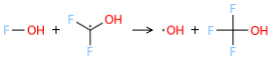

! Template reaction: F_Abstraction
! Flux pairs: CHO2(1070), S(1612); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
OF(321)+CHO2(1070)=OH(4)+S(1612)                    9.788150e+01 3.351     3.190    



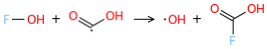

! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(39); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
OF(321)+CH3(19)=OH(4)+CH3F(39)                      3.982760e+06 1.789     6.672    



! Template reaction: F_Abstraction
! Flux pairs: S(1482), S(1481); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(321)+S(1482)=OH(4)+S(1481)                       2.856550e+00 3.303     1.701    



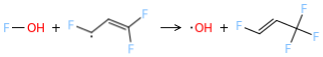

! Template reaction: F_Abstraction
! Flux pairs: OH(4), OF(321); FO2(126), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
FO2(126)+OH(4)=O2(2)+OF(321)                        1.233330e+05 2.473     11.848   



! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(56); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_N-Sp-4BrCFINOPSSi-3C
FO2(126)+C2H3(29)=O2(2)+CH2CHF(56)                  9.414390e+00 3.584     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(56); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_N-Sp-4BrCFINOPSSi-3C
OF(321)+C2H3(29)=OH(4)+CH2CHF(56)                   9.414390e+00 3.584     2.614    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(5896), C3H3(5898); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(5896)=HF(38)+C3H3(5898)                      5.182650e-03 4.748     16.657   



! Template reaction: F_Abstraction
! Flux pairs: C3H3(5898), S(5896); FO2(126), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(126)+C3H3(5898)=O2(2)+S(5896)                   2.856550e+00 3.303     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C3H3(5898), S(5896); OF(321), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
OF(321)+C3H3(5898)=OH(4)+S(5896)                    2.856550e+00 3.303     4.339    



! Template reaction: F_Abstraction
! Flux pairs: C2H3F2(65), CH3CF3(1); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(310)+C2H3F2(65)=O(7)+CH3CF3(1)                   8.855870e+04 2.371     8.435    



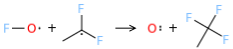

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO(310)+H(6)=O(7)+HF(38)                            1.041050e+06 2.314     3.550    



! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(310)+CH2CF(70)=O(7)+CH2CF2(57)                   8.855870e+04 2.371     8.098    



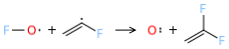

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(310)+CFO(51)=O(7)+CF2O(49)                       8.855870e+04 2.371     9.620    



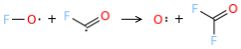

! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(310)+CF2CH(73)=O(7)+CHFCF2(55)                   1.969830e+01 3.066     2.411    



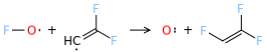

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(310)+C2HF2(72)=O(7)+CHFCF2(55)                   1.969830e+01 3.066     1.574    



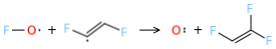

! Template reaction: F_Abstraction
! Flux pairs: S(125), S(739); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(310)+S(125)=O(7)+S(739)                          6.826940e+00 3.642     7.435    



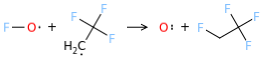

! Template reaction: F_Abstraction
! Flux pairs: C2H2F3(68), S(739); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(310)+C2H2F3(68)=O(7)+S(739)                      2.856550e+00 3.303     1.291    



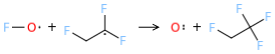

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(310)+CHF2(82)=O(7)+CHF3(42)                      8.855870e+04 2.371     8.444    



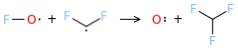

! Template reaction: F_Abstraction
! Flux pairs: S(1482), S(320); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(310)+S(1482)=O(7)+S(320)                         2.856550e+00 3.303     3.396    



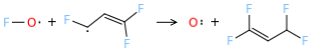

! Template reaction: F_Abstraction
! Flux pairs: CH2(T)(18), CH2F(46); FO(310), O(7); 
! Fitted to 50 data points; dA = *|/ 1.22333, dn = +|- 0.0264834, dEa = +|- 0.144122 kJ/molMatched reaction 87 [O]F_r12 + CH2 <=> [CH2]F_r12 + [O]_r3 in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_3R->O_N-1BrCClFHINPSSi-u0_N-3O-u1]
! family: F_Abstraction
FO(310)+CH2(T)(18)=O(7)+CH2F(46)                    9.967950e+02 2.978     9.855    



! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(310)+HCO(15)=O(7)+CHFO(47)                       2.084580e+03 2.800     3.303    



! Template reaction: F_Abstraction
! Flux pairs: S(2532), S(1486); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(310)+S(2532)=O(7)+S(1486)                        1.969830e+01 3.066     5.498    



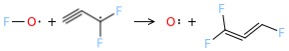

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(310)+C2HF4(54)=O(7)+C2HF5(81)                    6.826940e+00 3.642     5.844    



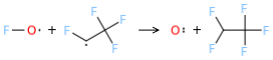

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(310)+C2HF4(69)=O(7)+C2HF5(81)                    6.826940e+00 3.642     4.450    



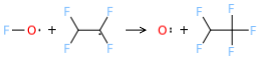

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(310)+CF3(45)=O(7)+CF4(44)                        8.855870e+04 2.371     7.900    



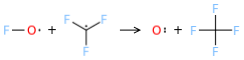

! Template reaction: F_Abstraction
! Flux pairs: CH2F(46), CH2F2(41); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0
FO(310)+CH2F(46)=O(7)+CH2F2(41)                     4.321000e+02 2.927     4.719    



! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(56); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(310)+C2H3(29)=O(7)+CH2CHF(56)                    2.084580e+03 2.800     2.921    



! Template reaction: F_Abstraction
! Flux pairs: S(2532), CF3CCH(84); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(310)+S(2532)=O(7)+CF3CCH(84)                     2.856550e+00 3.303     1.987    



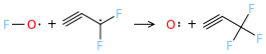

! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(310)+C2H2F(71)=O(7)+C2H2F2(59)                   1.969830e+01 3.066     2.517    



! Template reaction: F_Abstraction
! Flux pairs: CH(17), CHF(40); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO(310)+CH(17)=O(7)+CHF(40)                         3.982760e+06 1.789     4.614    



! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(39); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO(310)+CH3(19)=O(7)+CH3F(39)                       3.982760e+06 1.789     7.436    



! Template reaction: F_Abstraction
! Flux pairs: S(1482), S(1481); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(310)+S(1482)=O(7)+S(1481)                        2.856550e+00 3.303     2.099    



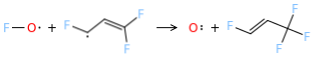

! Template reaction: F_Abstraction
! Flux pairs: CHO2(1070), S(1612); FO(310), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(310)+CHO2(1070)=O(7)+S(1612)                     8.855870e+04 2.371     9.399    



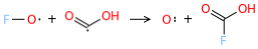

*******************************************************************************************************
CH3CHF2


Number of F_abstractions:     157 
Number of H_abstractions:     399 
Total reactions:              5056
F_abstraction percentage out of total reactions: 3.1 % 




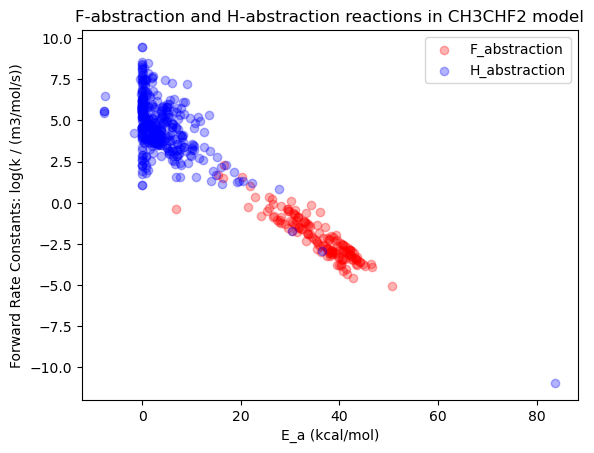

! Template reaction: F_Abstraction
! Flux pairs: CF2(43), CF(50); H(6), HF(38); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F]
! family: F_Abstraction
H(6)+CF2(43)=HF(38)+CF(50)                          1.085140e-36 14.363    6.864    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(181), C2H2O(610); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(181)=HF(38)+C2H2O(610)                       1.575380e-09 6.622     16.336   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(4983), C3H3(3341); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(4983)=HF(38)+C3H3(3341)                      1.575380e-09 6.622     15.378   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(2489), C3H3(3341); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(2489)=HF(38)+C3H3(3341)                      5.182650e-03 4.748     16.657   



*******************************************************************************************************
CH3F


Number of F_abstractions:     77 
Number of H_abstractions:     158 
Total reactions:              1504
F_abstraction percentage out of total reactions: 5.1 % 




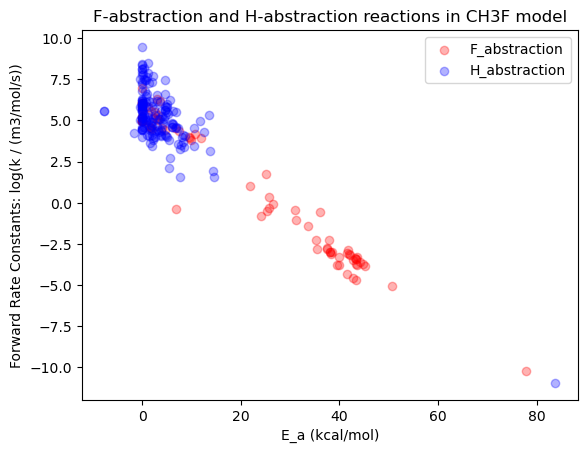

! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(1); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO2(124)+CH3(19)=O2(2)+CH3F(1)                      3.982760e+06 1.789     1.858    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO2(124)+H(6)=O2(2)+HF(38)                          1.041050e+06 2.314     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CH2(T)(18), CH2F(45); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_N-3C-u1_1O-u0_Ext-1O-R
FO2(124)+CH2(T)(18)=O2(2)+CH2F(45)                  1.786980e+02 3.259     1.094    



! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(46); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
FO2(124)+HCO(15)=O2(2)+CHFO(46)                     2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CHO2(141), CHFO2(173); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(124)+CHO2(141)=O2(2)+CHFO2(173)                 9.788150e+01 3.351     0.000    



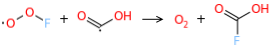

! Template reaction: F_Abstraction
! Flux pairs: CH2F(45), CH2F2(40); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CH2F(45)=O2(2)+CH2F2(40)                   1.198820e+01 3.287     0.000    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); CF2(42), CF(49); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule
! [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_3CClF->C_N-1CClH->C_Ext-3C-R_N-4R!H->Cl_N-4BrCFINOPSSi->C_N-4FO->O]
! family: F_Abstraction
H(6)+CF2(42)=HF(38)+CF(49)                          1.085140e-36 14.363    6.864    



! Template reaction: F_Abstraction
! Flux pairs: CF(49), CF2(42); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CF(49)=O2(2)+CF2(42)                       1.198820e+01 3.287     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CFO(50), CF2O(48); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CFO(50)=O2(2)+CF2O(48)                     1.198820e+01 3.287     0.000    



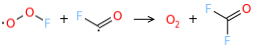

! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CHF3(41); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CHF2(81)=O2(2)+CHF3(41)                    1.198820e+01 3.287     0.000    



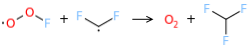

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(685), S(1705); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(124)+CHF2O(685)=O2(2)+S(1705)                   9.788150e+01 3.351     0.000    



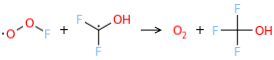

! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(1); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
OF(162)+CH3(19)=OH(4)+CH3F(1)                       3.982760e+06 1.789     6.672    



! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(46); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
OF(162)+HCO(15)=OH(4)+CHFO(46)                      2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
H(6)+OF(162)=HF(38)+OH(4)                           1.041050e+06 2.314     3.098    



! Template reaction: F_Abstraction
! Flux pairs: CH2F(45), CH2F2(40); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(162)+CH2F(45)=OH(4)+CH2F2(40)                    1.198820e+01 3.287     1.986    



! Template reaction: F_Abstraction
! Flux pairs: CHO2(141), CHFO2(173); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
OF(162)+CHO2(141)=OH(4)+CHFO2(173)                  9.788150e+01 3.351     3.190    



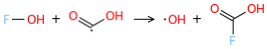

! Template reaction: F_Abstraction
! Flux pairs: CF(49), CF2(42); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(162)+CF(49)=OH(4)+CF2(42)                        1.198820e+01 3.287     1.503    



! Template reaction: F_Abstraction
! Flux pairs: CFO(50), CF2O(48); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(162)+CFO(50)=OH(4)+CF2O(48)                      1.198820e+01 3.287     1.783    



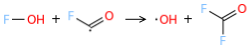

! Template reaction: F_Abstraction
! Flux pairs: CHF2O(685), S(1705); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
OF(162)+CHF2O(685)=OH(4)+S(1705)                    9.788150e+01 3.351     2.570    



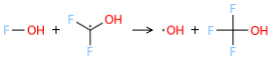

! Template reaction: F_Abstraction
! Flux pairs: CHF2(81), CHF3(41); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
OF(162)+CHF2(81)=OH(4)+CHF3(41)                     1.198820e+01 3.287     1.299    



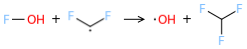

! Template reaction: F_Abstraction
! Flux pairs: OH(4), OF(162); FO2(124), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
FO2(124)+OH(4)=O2(2)+OF(162)                        1.233330e+05 2.473     11.848   



! Template reaction: F_Abstraction
! Flux pairs: CO3(204), CFO3(279); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(124)+CO3(204)=O2(2)+CFO3(279)                   9.788150e+01 3.351     0.000    



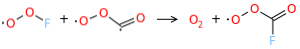

! Template reaction: F_Abstraction
! Flux pairs: CHO2(136), CHFO2(161); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(124)+CHO2(136)=O2(2)+CHFO2(161)                 1.198820e+01 3.287     0.000    



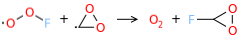

! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(55); FO2(124), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_N-Sp-4BrCFINOPSSi-3C
FO2(124)+C2H3(29)=O2(2)+CH2CHF(55)                  9.414390e+00 3.584     0.000    



! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(55); OF(162), OH(4); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_N-Sp-4BrCFINOPSSi-3C
OF(162)+C2H3(29)=OH(4)+CH2CHF(55)                   9.414390e+00 3.584     2.614    



! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(1); FO(294), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO(294)+CH3(19)=O(7)+CH3F(1)                        3.982760e+06 1.789     7.436    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO(294), O(7); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO(294)+H(6)=O(7)+HF(38)                            1.041050e+06 2.314     3.550    



! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(46); FO(294), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(294)+HCO(15)=O(7)+CHFO(46)                       2.084580e+03 2.800     3.303    



! Template reaction: F_Abstraction
! Flux pairs: CH2(T)(18), CH2F(45); FO(294), O(7); 
! Fitted to 50 data points; dA = *|/ 1.22333, dn = +|- 0.0264834, dEa = +|- 0.144122 kJ/molMatched reaction 87 [O]F_r12 + CH2 <=> [CH2]F_r12 + [O]_r3 in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_3R->O_N-1BrCClFHINPSSi-u0_N-3O-u1]
! family: F_Abstraction
FO(294)+CH2(T)(18)=O(7)+CH2F(45)                    9.967950e+02 2.978     9.855    



! Template reaction: F_Abstraction
! Flux pairs: CH2F(45), CH2F2(40); FO(294), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0
FO(294)+CH2F(45)=O(7)+CH2F2(40)                     4.321000e+02 2.927     4.719    



! Template reaction: F_Abstraction
! Flux pairs: C2H3(29), CH2CHF(55); FO(294), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(294)+C2H3(29)=O(7)+CH2CHF(55)                    2.084580e+03 2.800     2.921    



! Template reaction: F_Abstraction
! Flux pairs: CHO2(141), CHFO2(173); FO(294), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(294)+CHO2(141)=O(7)+CHFO2(173)                   8.855870e+04 2.371     9.399    



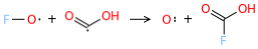

! Template reaction: F_Abstraction
! Flux pairs: CF(49), CF2(42); FO(294), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0
FO(294)+CF(49)=O(7)+CF2(42)                         4.321000e+02 2.927     3.943    



! Template reaction: F_Abstraction
! Flux pairs: CFO(50), CF2O(48); FO(294), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(294)+CFO(50)=O(7)+CF2O(48)                       8.855870e+04 2.371     9.620    



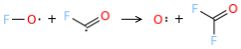

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(294); FO2(124), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
O(7)+FO2(124)=FO(294)+O2(2)                         1.233330e+05 2.473     10.715   



*******************************************************************************************************
CHFCFCF3


Number of F_abstractions:     215 
Number of H_abstractions:     134 
Total reactions:              3244
F_abstraction percentage out of total reactions: 6.6 % 




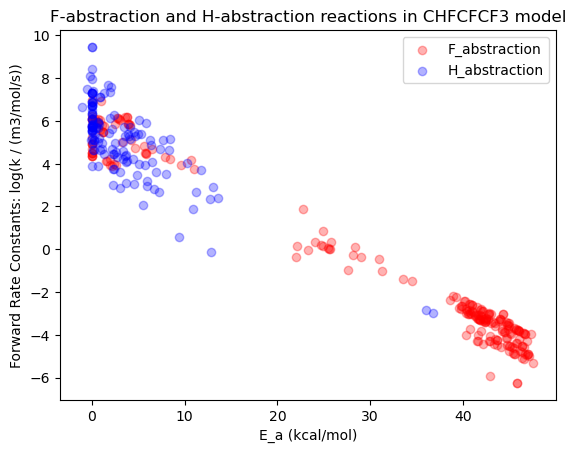

! Template reaction: F_Abstraction
! Flux pairs: C3HF4(166), C3HF5(146); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
! Multiplied by reaction path degeneracy 2.0
FO(1172)+C3HF4(166)=O(7)+C3HF5(146)                 5.713100e+00 3.303     1.937    



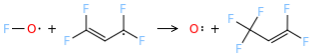

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1172)+CF3CO(74)=O(7)+CF3COF(77)                  6.826940e+00 3.642     5.805    



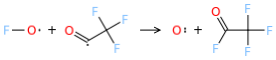

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(1172)+HCO(15)=O(7)+CHFO(47)                      2.084580e+03 2.800     3.303    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO(1172)+H(6)=O(7)+HF(38)                           1.041050e+06 2.314     3.550    



! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1172)+CF2CH(73)=O(7)+CHFCF2(55)                  1.969830e+01 3.066     2.411    



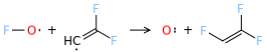

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1172)+C2HF2(72)=O(7)+CHFCF2(55)                  1.969830e+01 3.066     1.574    



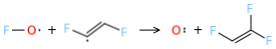

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(1172)+CFO(51)=O(7)+CF2O(49)                      8.855870e+04 2.371     9.620    



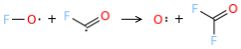

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(1172)+CF3(45)=O(7)+CF4(44)                       8.855870e+04 2.371     7.900    



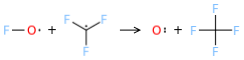

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(1172)+CHF2(82)=O(7)+CHF3(42)                     8.855870e+04 2.371     8.444    



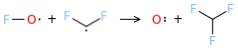

! Template reaction: F_Abstraction
! Flux pairs: S(7121), CF3CCH(84); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(1172)+S(7121)=O(7)+CF3CCH(84)                    2.856550e+00 3.303     1.987    



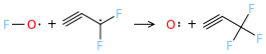

! Template reaction: F_Abstraction
! Flux pairs: S(11277), C3F3(8085); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(1172)+S(11277)=O(7)+C3F3(8085)                   2.856550e+00 3.303     2.172    



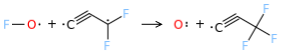

! Template reaction: F_Abstraction
! Flux pairs: C3HF4(166), C3HF5(146); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
! Multiplied by reaction path degeneracy 2.0
FO2(142)+C3HF4(166)=O2(2)+C3HF5(146)                5.713100e+00 3.303     0.000    



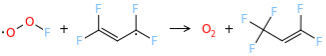

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(142)+CF3CO(74)=O2(2)+CF3COF(77)                 6.826940e+00 3.642     1.223    



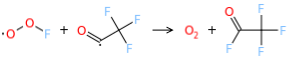

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0
FO2(142)+HCO(15)=O2(2)+CHFO(47)                     2.677620e-01 3.934     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(142)+CF2CH(73)=O2(2)+CHFCF2(55)                 1.969830e+01 3.066     0.000    



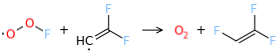

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(142)+C2HF2(72)=O2(2)+CHFCF2(55)                 1.969830e+01 3.066     0.000    



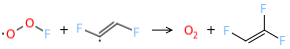

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO2(142)+H(6)=O2(2)+HF(38)                          1.041050e+06 2.314     0.000    



! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(142)+CFO(51)=O2(2)+CF2O(49)                     1.198820e+01 3.287     0.000    



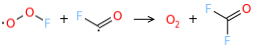

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(142)+CF3(45)=O2(2)+CF4(44)                      1.198820e+01 3.287     0.000    



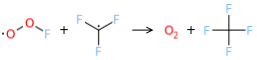

! Template reaction: F_Abstraction
! Flux pairs: S(1627), CF3CHO(75); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(142)+S(1627)=O2(2)+CF3CHO(75)                   2.856550e+00 3.303     0.000    



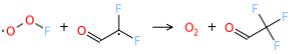

! Template reaction: F_Abstraction
! Flux pairs: S(4059), S(1851); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(142)+S(4059)=O2(2)+S(1851)                      6.826940e+00 3.642     0.942    



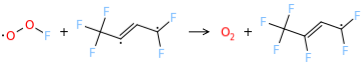

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C
FO2(142)+CHF2(82)=O2(2)+CHF3(42)                    1.198820e+01 3.287     0.000    



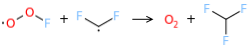

! Template reaction: F_Abstraction
! Flux pairs: S(1628), C3F5O(246); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FO2(142)+S(1628)=O2(2)+C3F5O(246)                   1.365388e+01 3.642     1.369    



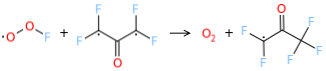

! Template reaction: F_Abstraction
! Flux pairs: S(7121), CF3CCH(84); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(142)+S(7121)=O2(2)+CF3CCH(84)                   2.856550e+00 3.303     0.000    



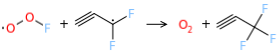

! Template reaction: F_Abstraction
! Flux pairs: S(11277), C3F3(8085); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO2(142)+S(11277)=O2(2)+C3F3(8085)                  2.856550e+00 3.303     0.000    



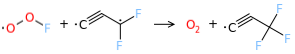

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(1172); FO2(142), O2(2); 
! Estimated from node Root_1R->O_3R->O_Ext-1O-R_N-4R!H->C
O(7)+FO2(142)=FO(1172)+O2(2)                        1.233330e+05 2.473     10.715   



! Template reaction: F_Abstraction
! Flux pairs: C3HF4(166), C3HF5(146); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 4.0
F2(78)+C3HF4(166)=F(37)+C3HF5(146)                  1.060000e+13 0.000     3.830    



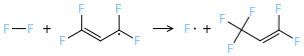

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); F2(78), F(37); 
! Fitted to 50 data points; dA = *|/ 1.09714, dn = +|- 0.0121793, dEa = +|- 0.066279 kJ/molMatched reaction 52 F2 + H <=> HF + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_N-1CClH->C_3ClF->F]
! family: F_Abstraction
F2(78)+H(6)=F(37)+HF(38)                            5.872910e+10 0.786     0.975    



! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+CF2CH(73)=F(37)+CHFCF2(55)                   2.233560e+03 2.918     0.622    



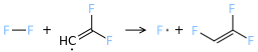

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2HF2(72)=F(37)+CHFCF2(55)                   5.300000e+12 0.000     2.758    



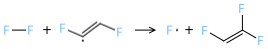

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); F2(78), F(37); 
! Fitted to 50 data points; dA = *|/ 1.07704, dn = +|- 0.00975049, dEa = +|- 0.0530618 kJ/molMatched reaction 67 F2 + CFO <=> CF2O + F in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_4R!H->O]
! family: F_Abstraction
F2(78)+CFO(51)=F(37)+CF2O(49)                       9.337540e+03 2.741     0.381    



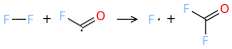

! Template reaction: F_Abstraction
! Flux pairs: CF3CO(74), CF3COF(77); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CF3CO(74)=F(37)+CF3COF(77)                   9.690860e+03 2.746     0.849    



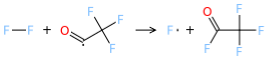

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+HCO(15)=F(37)+CHFO(47)                       9.690860e+03 2.746     0.630    



! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); F2(78), F(37); 
! Matched reaction 0 F2 + CF3 <=> CF4_p23 + F_p1 in F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_N-3CClFH->H_N-3CClF->C_1CClH->C_Ext-1C-R_N-4R!H->O]
! family: F_Abstraction
F2(78)+CF3(45)=F(37)+CF4(44)                        2.650000e+12 0.000     2.500    



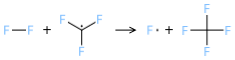

! Template reaction: F_Abstraction
! Flux pairs: S(7121), CF3CCH(84); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+S(7121)=F(37)+CF3CCH(84)                     5.300000e+12 0.000     3.893    



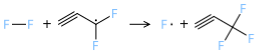

! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+CHF2(82)=F(37)+CHF3(42)                      5.300000e+12 0.000     2.786    



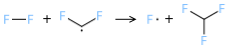

! Template reaction: F_Abstraction
! Flux pairs: O(7), FO(1172); F2(78), F(37); 
! Estimated from node Root_N-1R->O_3R->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+O(7)=F(37)+FO(1172)                          7.611020e-02 4.416     10.969   



! Template reaction: F_Abstraction
! Flux pairs: S(11277), C3F3(8085); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+S(11277)=F(37)+C3F3(8085)                    5.300000e+12 0.000     4.121    



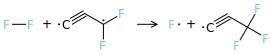

! Template reaction: F_Abstraction
! Flux pairs: C2F5(1274), C2F6(53); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(142)+C2F5(1274)=O2(2)+C2F6(53)                  6.826940e+00 3.642     0.000    



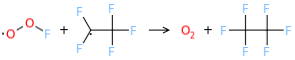

! Template reaction: F_Abstraction
! Flux pairs: C2F5(1274), C2F6(53); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1172)+C2F5(1274)=O(7)+C2F6(53)                   6.826940e+00 3.642     4.613    



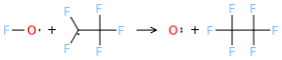

! Template reaction: F_Abstraction
! Flux pairs: C2F5(1274), C2F6(53); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2F5(1274)=F(37)+C2F6(53)                    5.300000e+12 0.000     3.085    



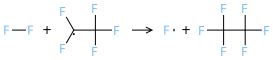

! Template reaction: F_Abstraction
! Flux pairs: C2F3(251), CF2CF2(61); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO2(142)+C2F3(251)=O2(2)+CF2CF2(61)                 1.969830e+01 3.066     0.000    



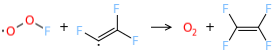

! Template reaction: F_Abstraction
! Flux pairs: C2F3(251), CF2CF2(61); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1172)+C2F3(251)=O(7)+CF2CF2(61)                  1.969830e+01 3.066     1.697    



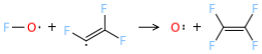

! Template reaction: F_Abstraction
! Flux pairs: C2F3(251), CF2CF2(61); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2F3(251)=F(37)+CF2CF2(61)                   5.300000e+12 0.000     2.906    



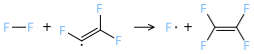

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(287), CF3COF(77); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(142)+C2F3O(287)=O2(2)+CF3COF(77)                6.826940e+00 3.642     1.251    



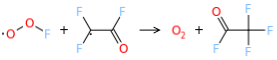

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(287), CF3COF(77); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1172)+C2F3O(287)=O(7)+CF3COF(77)                 6.826940e+00 3.642     5.885    



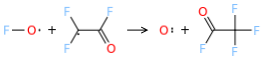

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(287), CF3COF(77); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C2F3O(287)=F(37)+CF3COF(77)                  5.300000e+12 0.000     4.051    



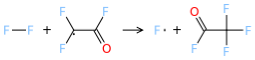

! Template reaction: F_Abstraction
! Flux pairs: C3F3(3535), C3F4(169); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_N-Sp-4BrCFINOPSSi-3C
FO2(142)+C3F3(3535)=O2(2)+C3F4(169)                 1.719080e+01 3.598     4.270    



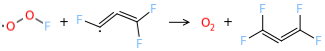

! Template reaction: F_Abstraction
! Flux pairs: C3F3(3535), C3F4(169); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1172)+C3F3(3535)=O(7)+C3F4(169)                  1.969830e+01 3.066     2.581    



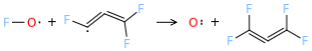

! Template reaction: F_Abstraction
! Flux pairs: C3F3(3535), C3F4(169); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+C3F3(3535)=F(37)+C3F4(169)                   5.300000e+12 0.000     3.915    



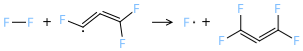

! Template reaction: F_Abstraction
! Flux pairs: S(11277), C3F3(3535); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_N-3C-u1_1O-u0_Ext-3C-R_Ext-1O-R
FO2(142)+S(11277)=O2(2)+C3F3(3535)                  1.889560e+07 1.605     0.000    



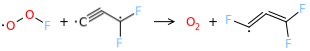

! Template reaction: F_Abstraction
! Flux pairs: S(11277), C3F3(3535); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_N-3C-u1_N-1O-u0_Ext-3C-R
FO(1172)+S(11277)=O(7)+C3F3(3535)                   3.911960e+04 2.500     6.445    



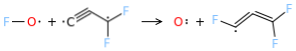

! Template reaction: F_Abstraction
! Flux pairs: S(11277), C3F3(3535); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+S(11277)=F(37)+C3F3(3535)                    2.233560e+03 2.918     0.000    



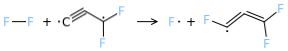

! Template reaction: F_Abstraction
! Flux pairs: S(1306), S(1236); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-
! Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_1O-u0_Sp-4BrCFINOPSSi-3C_N-4BrCFINOPSSi->C
FO2(142)+S(1306)=O2(2)+S(1236)                      9.788150e+01 3.351     0.000    



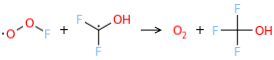

! Template reaction: F_Abstraction
! Flux pairs: S(1306), S(1236); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_4R!H->O
! Multiplied by reaction path degeneracy 2.0
F2(78)+S(1306)=F(37)+S(1236)                        9.690860e+03 2.746     0.000    



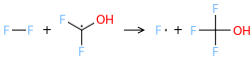

! Template reaction: F_Abstraction
! Flux pairs: C3F5(252), C3F6(2294); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FO2(142)+C3F5(252)=O2(2)+C3F6(2294)                 1.365388e+01 3.642     1.149    



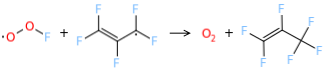

! Template reaction: F_Abstraction
! Flux pairs: C3F5(168), C3F6(2294); FO2(142), O2(2); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO2(142)+C3F5(168)=O2(2)+C3F6(2294)                 6.826940e+00 3.642     1.192    



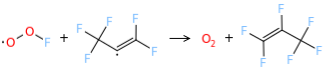

! Template reaction: F_Abstraction
! Flux pairs: C3F5(252), C3F6(2294); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
! Multiplied by reaction path degeneracy 2.0
FO(1172)+C3F5(252)=O(7)+C3F6(2294)                  1.365388e+01 3.642     5.586    



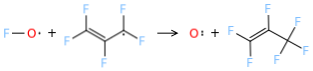

! Template reaction: F_Abstraction
! Flux pairs: C3F5(168), C3F6(2294); FO(1172), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1172)+C3F5(168)=O(7)+C3F6(2294)                  6.826940e+00 3.642     5.713    



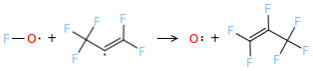

! Template reaction: F_Abstraction
! Flux pairs: C3F5(252), C3F6(2294); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R_N-4R!H->O
! Multiplied by reaction path degeneracy 4.0
F2(78)+C3F5(252)=F(37)+C3F6(2294)                   1.060000e+13 0.000     3.823    



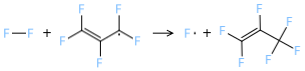

! Template reaction: F_Abstraction
! Flux pairs: C3F5(168), C3F6(2294); F2(78), F(37); 
! Estimated from node Root_N-1R->O_N-3R->O_1BrCClFHINPSSi->F_Ext-3CClFH-R
! Multiplied by reaction path degeneracy 2.0
F2(78)+C3F5(168)=F(37)+C3F6(2294)                   2.233560e+03 2.918     0.698    



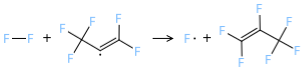

*******************************************************************************************************
CHFCFCH3


Number of F_abstractions:     27 
Number of H_abstractions:     62 
Total reactions:              975
F_abstraction percentage out of total reactions: 2.8 % 




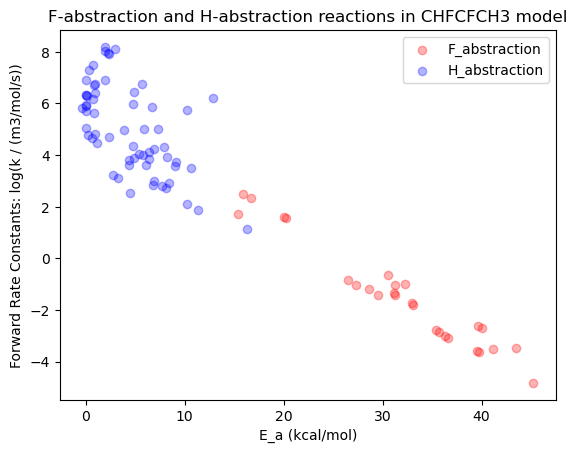

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); C3H3F(133), C3H3(167); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+C3H3F(133)=HF(38)+C3H3(167)                    1.575380e-09 6.622     15.378   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); C#CCF(542), C3H3(167); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+C#CCF(542)=HF(38)+C3H3(167)                    5.182650e-03 4.748     16.657   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(197), C3H4F(596); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(197)=HF(38)+C3H4F(596)                       5.182650e-03 4.748     15.930   



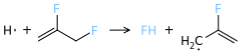

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(581), S(128); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F_Ext-1C-R_N-5R!H->F_5BrCClINOPSSi->C
! Multiplied by reaction path degeneracy 2.0
H(6)+S(581)=HF(38)+S(128)                           3.697300e-04 5.139     19.985   



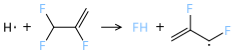

*******************************************************************************************************
HFO-1234yf


Number of F_abstractions:     385 
Number of H_abstractions:     426 
Total reactions:              5014
F_abstraction percentage out of total reactions: 7.7 % 




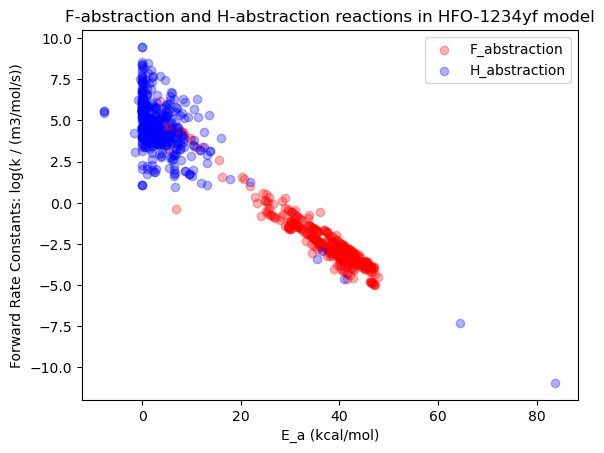

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(124), S(125); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(124)=HF(38)+S(125)                           5.182650e-03 4.748     15.522   



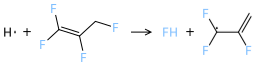

! Template reaction: F_Abstraction
! Flux pairs: C3HF3(150), S(2801); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+C3HF3(150)=HF(38)+S(2801)                      1.575380e-09 6.622     16.092   



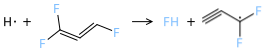

! Template reaction: F_Abstraction
! Flux pairs: S(125), C3H2F4(1); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1887)+S(125)=O(7)+C3H2F4(1)                      6.826940e+00 3.642     5.739    



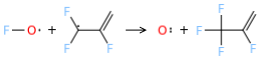

! Template reaction: F_Abstraction
! Flux pairs: CH2CF(70), CH2CF2(57); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(1887)+CH2CF(70)=O(7)+CH2CF2(57)                  8.855870e+04 2.371     8.098    



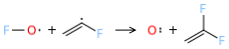

! Template reaction: F_Abstraction
! Flux pairs: S(145), S(141); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(1887)+S(145)=O(7)+S(141)                         2.856550e+00 3.303     2.099    



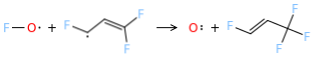

! Template reaction: F_Abstraction
! Flux pairs: C2F3O(365), CF3COF(77); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1887)+C2F3O(365)=O(7)+CF3COF(77)                 6.826940e+00 3.642     5.885    



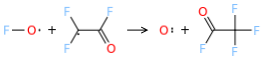

! Template reaction: F_Abstraction
! Flux pairs: S(125), S(124); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1887)+S(125)=O(7)+S(124)                         6.826940e+00 3.642     11.011   



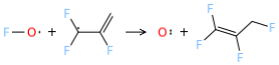

! Template reaction: F_Abstraction
! Flux pairs: CFO(51), CF2O(49); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(1887)+CFO(51)=O(7)+CF2O(49)                      8.855870e+04 2.371     9.620    



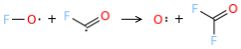

! Template reaction: F_Abstraction
! Flux pairs: C2H(22), C2HF(58); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(1887)+C2H(22)=O(7)+C2HF(58)                      1.259270e+03 2.989     12.229   



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_N-3CClFH->C
FO(1887)+H(6)=O(7)+HF(38)                           1.041050e+06 2.314     3.550    



! Template reaction: F_Abstraction
! Flux pairs: CH2(T)(18), CH2F(46); FO(1887), O(7); 
! Fitted to 50 data points; dA = *|/ 1.22333, dn = +|- 0.0264834, dEa = +|- 0.144122 kJ/molMatched reaction 87 [O]F_r12 + CH2 <=> [CH2]F_r12 + [O]_r3 in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_3R->O_N-1BrCClFHINPSSi-u0_N-3O-u1]
! family: F_Abstraction
FO(1887)+CH2(T)(18)=O(7)+CH2F(46)                   9.967950e+02 2.978     9.855    



! Template reaction: F_Abstraction
! Flux pairs: CF2CH(73), CHFCF2(55); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1887)+CF2CH(73)=O(7)+CHFCF2(55)                  1.969830e+01 3.066     2.411    



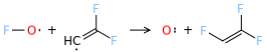

! Template reaction: F_Abstraction
! Flux pairs: C2HF2(72), CHFCF2(55); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1887)+C2HF2(72)=O(7)+CHFCF2(55)                  1.969830e+01 3.066     1.574    



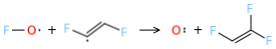

! Template reaction: F_Abstraction
! Flux pairs: CF3(45), CF4(44); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(1887)+CF3(45)=O(7)+CF4(44)                       8.855870e+04 2.371     7.900    



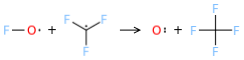

! Template reaction: F_Abstraction
! Flux pairs: S(145), S(144); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(1887)+S(145)=O(7)+S(144)                         2.856550e+00 3.303     3.396    



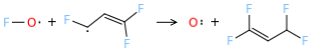

! Template reaction: F_Abstraction
! Flux pairs: HCO(15), CHFO(47); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C
FO(1887)+HCO(15)=O(7)+CHFO(47)                      2.084580e+03 2.800     3.303    



! Template reaction: F_Abstraction
! Flux pairs: S(2801), C3HF3(150); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1887)+S(2801)=O(7)+C3HF3(150)                    1.969830e+01 3.066     5.498    



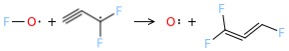

! Template reaction: F_Abstraction
! Flux pairs: CH2F(46), CH2F2(41); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0
FO(1887)+CH2F(46)=O(7)+CH2F2(41)                    4.321000e+02 2.927     4.719    



! Template reaction: F_Abstraction
! Flux pairs: CHF2(82), CHF3(42); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0_Ext-3C-R
FO(1887)+CHF2(82)=O(7)+CHF3(42)                     8.855870e+04 2.371     8.444    



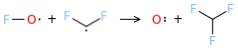

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(54), C2HF5(81); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1887)+C2HF4(54)=O(7)+C2HF5(81)                   6.826940e+00 3.642     5.844    



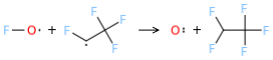

! Template reaction: F_Abstraction
! Flux pairs: C2HF4(69), C2HF5(81); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1887)+C2HF4(69)=O(7)+C2HF5(81)                   6.826940e+00 3.642     4.450    



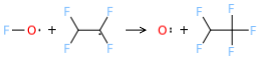

! Template reaction: F_Abstraction
! Flux pairs: C3H3F4(86), S(4144); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C_Ext-4BrCFINOPSSi-R
FO(1887)+C3H3F4(86)=O(7)+S(4144)                    6.826940e+00 3.642     5.619    



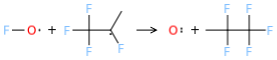

! Template reaction: F_Abstraction
! Flux pairs: C2F3(545), CF2CF2(61); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1887)+C2F3(545)=O(7)+CF2CF2(61)                  1.969830e+01 3.066     1.697    



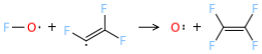

! Template reaction: F_Abstraction
! Flux pairs: S(2801), CF3CCH(83); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(1887)+S(2801)=O(7)+CF3CCH(83)                    2.856550e+00 3.303     1.987    



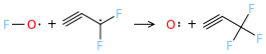

! Template reaction: F_Abstraction
! Flux pairs: C2H2F(71), C2H2F2(59); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R
FO(1887)+C2H2F(71)=O(7)+C2H2F2(59)                  1.969830e+01 3.066     2.517    



! Template reaction: F_Abstraction
! Flux pairs: CH(17), CHF(40); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO(1887)+CH(17)=O(7)+CHF(40)                        3.982760e+06 1.789     4.614    



! Template reaction: F_Abstraction
! Flux pairs: CF(50), CF2(43); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_N-Sp-4BrBrBrCCCFFFIIINNNOOOPPPSSSSiSiSi#3C_N-1O-u0
FO(1887)+CF(50)=O(7)+CF2(43)                        4.321000e+02 2.927     3.943    



! Template reaction: F_Abstraction
! Flux pairs: CF2(43), CF(50); H(6), HF(38); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F]
! family: F_Abstraction
H(6)+CF2(43)=HF(38)+CF(50)                          1.085140e-36 14.363    6.864    



! Template reaction: F_Abstraction
! Flux pairs: C(T)(16), CF(50); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_N-3C-u1_N-1O-u0
FO(1887)+C(T)(16)=O(7)+CF(50)                       1.203830e+03 2.954     7.554    



! Template reaction: F_Abstraction
! Flux pairs: CH3(19), CH3F(39); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1
FO(1887)+CH3(19)=O(7)+CH3F(39)                      3.982760e+06 1.789     7.436    



! Template reaction: F_Abstraction
! Flux pairs: S(5385), S(5433); FO(1887), O(7); 
! Estimated from node Root_1R->O_N-3R->O_3CClFH->C_3C-u1_Ext-3C-R_N-4R!H->Cl_Ext-4BrCFINOPSSi-R_Sp-4BrCFINOPSSi-3C
FO(1887)+S(5385)=O(7)+S(5433)                       2.856550e+00 3.303     3.593    



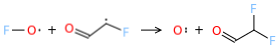

*******************************************************************************************************
HFO-1234yf_no_dispropy


Number of F_abstractions:     295 
Number of H_abstractions:     474 
Total reactions:              4474
F_abstraction percentage out of total reactions: 6.6 % 




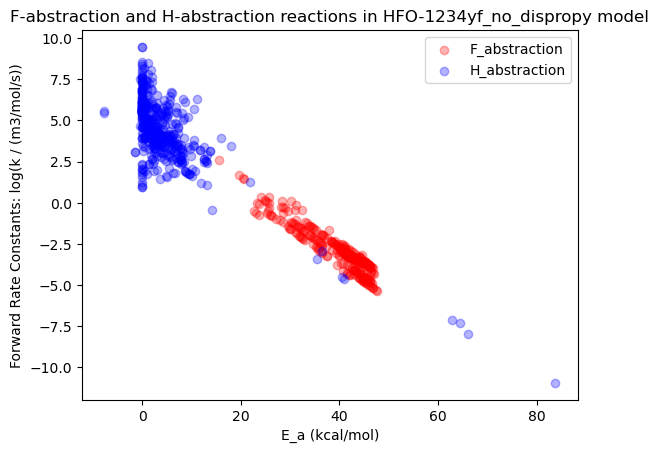

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(124), S(125); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_4BrCClINOPSSi->C
H(6)+S(124)=HF(38)+S(125)                           5.182650e-03 4.748     15.522   



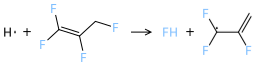

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); CF2CO(76), C2FO(2654); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F_Ext-1C-R_N-5R!H->F_5BrCClINOPSSi->C
! Multiplied by reaction path degeneracy 2.0
H(6)+CF2CO(76)=HF(38)+C2FO(2654)                    3.697300e-04 5.139     19.573   



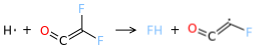

*******************************************************************************************************
HFO-1336mzz


Number of F_abstractions:     100 
Number of H_abstractions:     346 
Total reactions:              3187
F_abstraction percentage out of total reactions: 3.1 % 




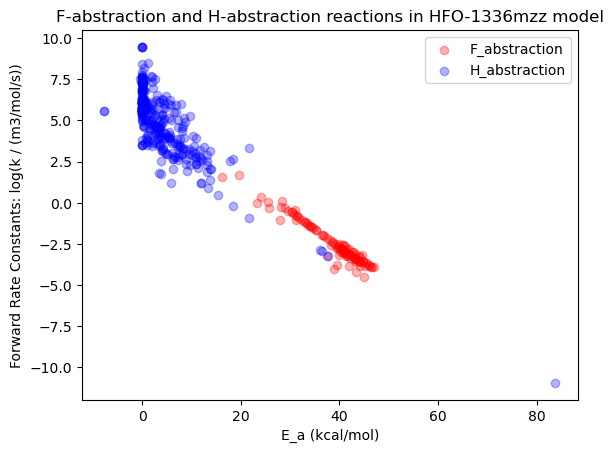

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); CF2CO(76), C2FO(394); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F_Ext-1C-R_N-5R!H->F_5BrCClINOPSSi->C
! Multiplied by reaction path degeneracy 2.0
H(6)+CF2CO(76)=HF(38)+C2FO(394)                     3.697300e-04 5.139     19.573   



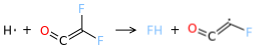

! Template reaction: F_Abstraction
! Flux pairs: C3HF3(375), S(2738); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+C3HF3(375)=HF(38)+S(2738)                      1.575380e-09 6.622     16.092   



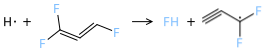

*******************************************************************************************************
R1234ze(E)


Number of F_abstractions:     156 
Number of H_abstractions:     266 
Total reactions:              2897
F_abstraction percentage out of total reactions: 5.4 % 




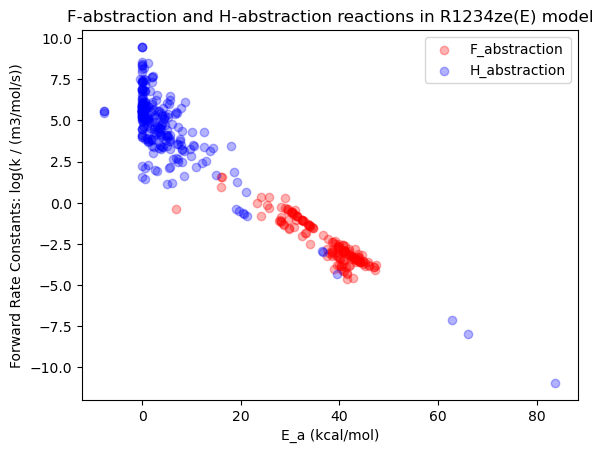

! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(4330), S(169); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F_Ext-1C-R
H(6)+S(4330)=HF(38)+S(169)                          4.826740e-15 8.251     15.963   



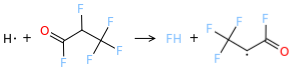

! Template reaction: F_Abstraction
! Flux pairs: CF2(43), CF(50); H(6), HF(38); 
! Fitted to 50 data points; dA = *|/ 1087.21, dn = +|- 0.918527, dEa = +|- 4.99859 kJ/molMatched reaction 72 CF2 + H <=> HF + CF in
! F_Abstraction/training
! This reaction matched rate rule [Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_4R!H->F]
! family: F_Abstraction
H(6)+CF2(43)=HF(38)+CF(50)                          1.085140e-36 14.363    6.864    



! Template reaction: F_Abstraction
! Flux pairs: H(6), HF(38); S(2158), HCCO(21); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+S(2158)=HF(38)+HCCO(21)                        1.575380e-09 6.622     16.047   



! Template reaction: F_Abstraction
! Flux pairs: C3HF3(133), S(10166); H(6), HF(38); 
! Estimated from node Root_N-1R->O_N-3R->O_N-1BrCClFHINPSSi->F_3CClFH->H_1CClH->C_Ext-1C-R_N-4R!H->F
H(6)+C3HF3(133)=HF(38)+S(10166)                     1.575380e-09 6.622     16.092   



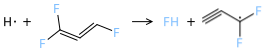

*******************************************************************************************************
R471A


Number of F_abstractions:     102 
Number of H_abstractions:     115 
Total reactions:              1743
F_abstraction percentage out of total reactions: 5.9 % 




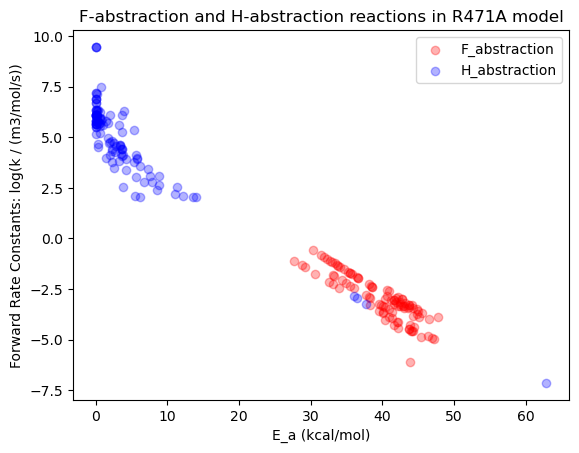

In [46]:
#user defined variables
full_path = '/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/F_abs/DF_models/rmg_combustion_paper_FFCM/refrigerants'
files_to_exclude = ['blend']
get_Eas_rates(full_path, files_to_exclude, "Refrigerants", T, P)
